In [1]:
import pandas as pd # Data manipulation and analysis
import numpy as np # Arrays and matrices
from datetime import datetime # Manipulating dates and times
import math

# Data visualization
import matplotlib.pyplot as plt # Combine pyplot with numpy into a single namespace
import matplotlib as mpl
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# Style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Same random numbers (debug mode)
np.random.seed(238746)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
# Normalization
def nor_data(df):
    return (df - df.mean()) / df.std()

In [4]:
# Open dataset from .csv file, with index column as date (first unnamed column in the file)
dataset = pd.read_csv('data/step2.csv', index_col=0, parse_dates=[0])
dataset.head()

,sku,pack,size,brand,price,exposed,promo,sales,scope,target,nor,cluster
date,,,,,,,,,,,,
2016-12-10,144,MULTI,114.23,BRAND2,2.18,45.0,100.000000,51320.0,1,51320.0,0.291411,1
2016-12-17,144,MULTI,114.23,BRAND2,2.00,45.0,100.000000,51320.0,1,66431.0,0.291411,1
2016-12-24,144,MULTI,114.23,BRAND2,2.05,17.0,100.000000,66431.0,1,57001.0,0.818564,1
2016-12-31,144,MULTI,114.23,BRAND2,3.00,2.0,100.000000,57001.0,1,15052.0,0.489595,1
2017-01-07,144,MULTI,114.23,BRAND2,2.99,2.0,28.534193,15052.0,1,22016.0,-0.973811,1


In [5]:
# Open dataset from .csv file, with index column as date (first unnamed column in the file)
testset = pd.read_csv('data/x_test_no_we.csv', index_col=0, parse_dates=[0])

# Rename columns to single-word
testset.rename(columns={'size (GM)': 'size', 'POS_exposed w-1': 'exposed', 'volume_on_promo w-1': 'promo', 'sales w-1': 'sales'}, inplace=True)
testset.rename_axis('date', inplace=True)
testset.head()

,sku,pack,size,brand,price,exposed,promo,sales,scope
date,,,,,,,,,
2019-06-29,1027,SINGLE,114.23,BRAND2,0.56,10.0,24.386541,66337.0,1
2019-07-06,1027,SINGLE,114.23,BRAND2,0.55,4.0,37.437842,49992.0,1
2019-07-13,1027,SINGLE,114.23,BRAND2,0.45,0.0,28.039623,58062.0,1
2019-07-20,1027,SINGLE,114.23,BRAND2,0.50,19.0,100.000000,90908.0,1
2019-07-27,1027,SINGLE,114.23,BRAND2,0.42,26.0,99.191839,108957.0,1


# Autocorrelation

We plot the autocorrelation on the products in the scope, sorted by cluster. We can see that in the first cluster the most important steps are t-1 and t-2, while for the second cluster t-1, t-2, t-3. We are going to use this information in our future analysis.

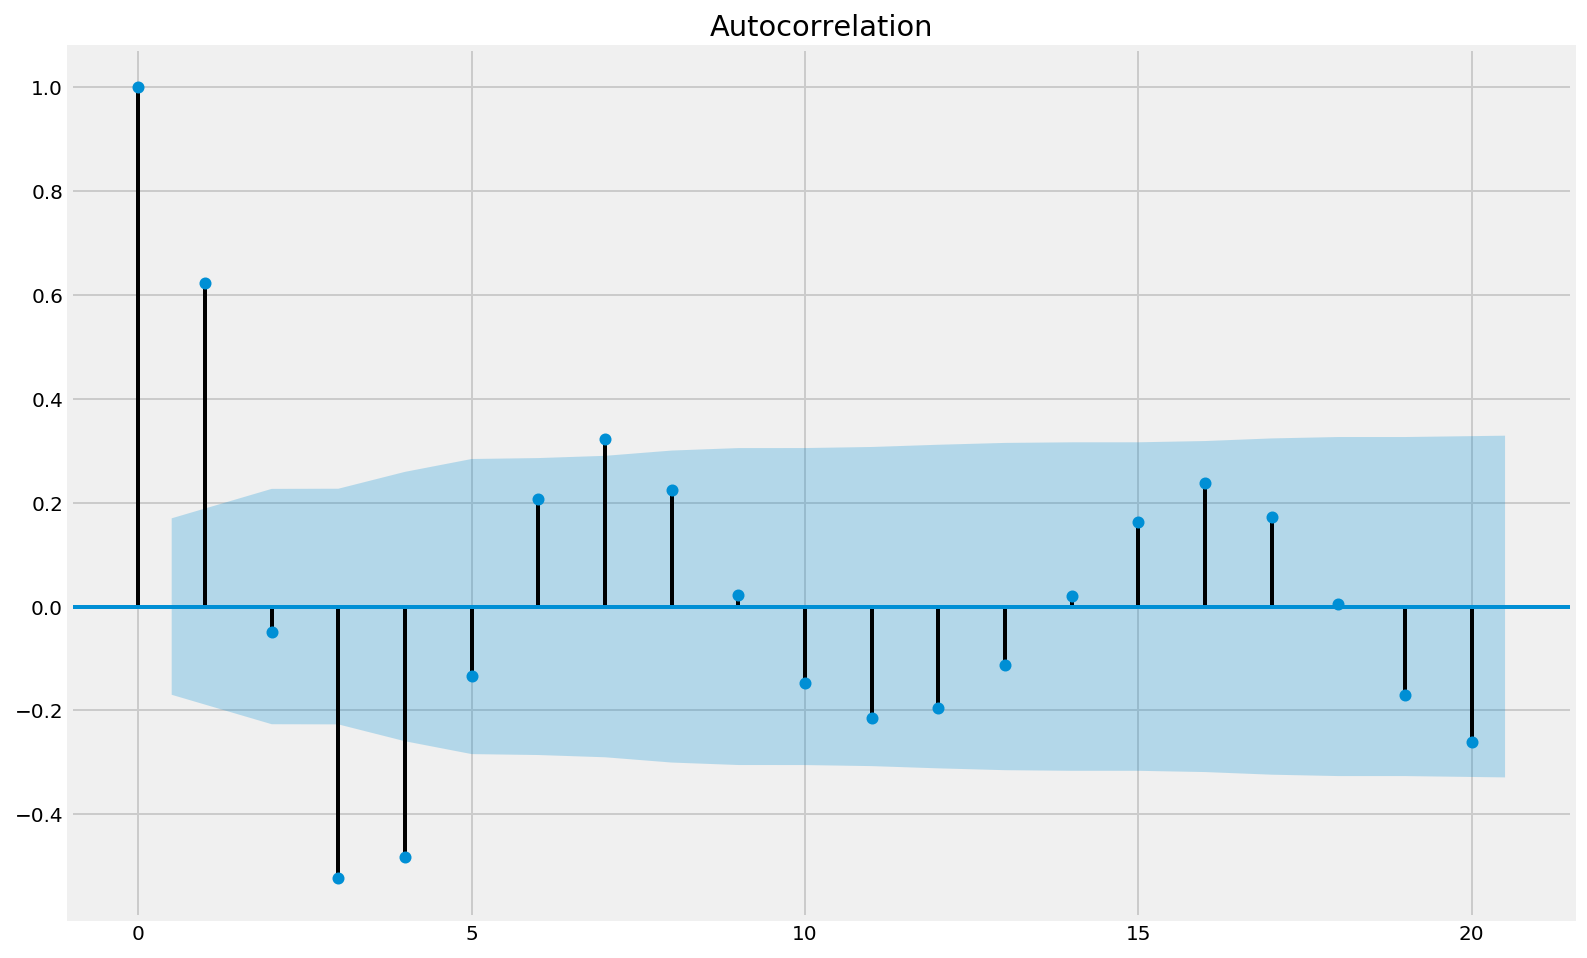

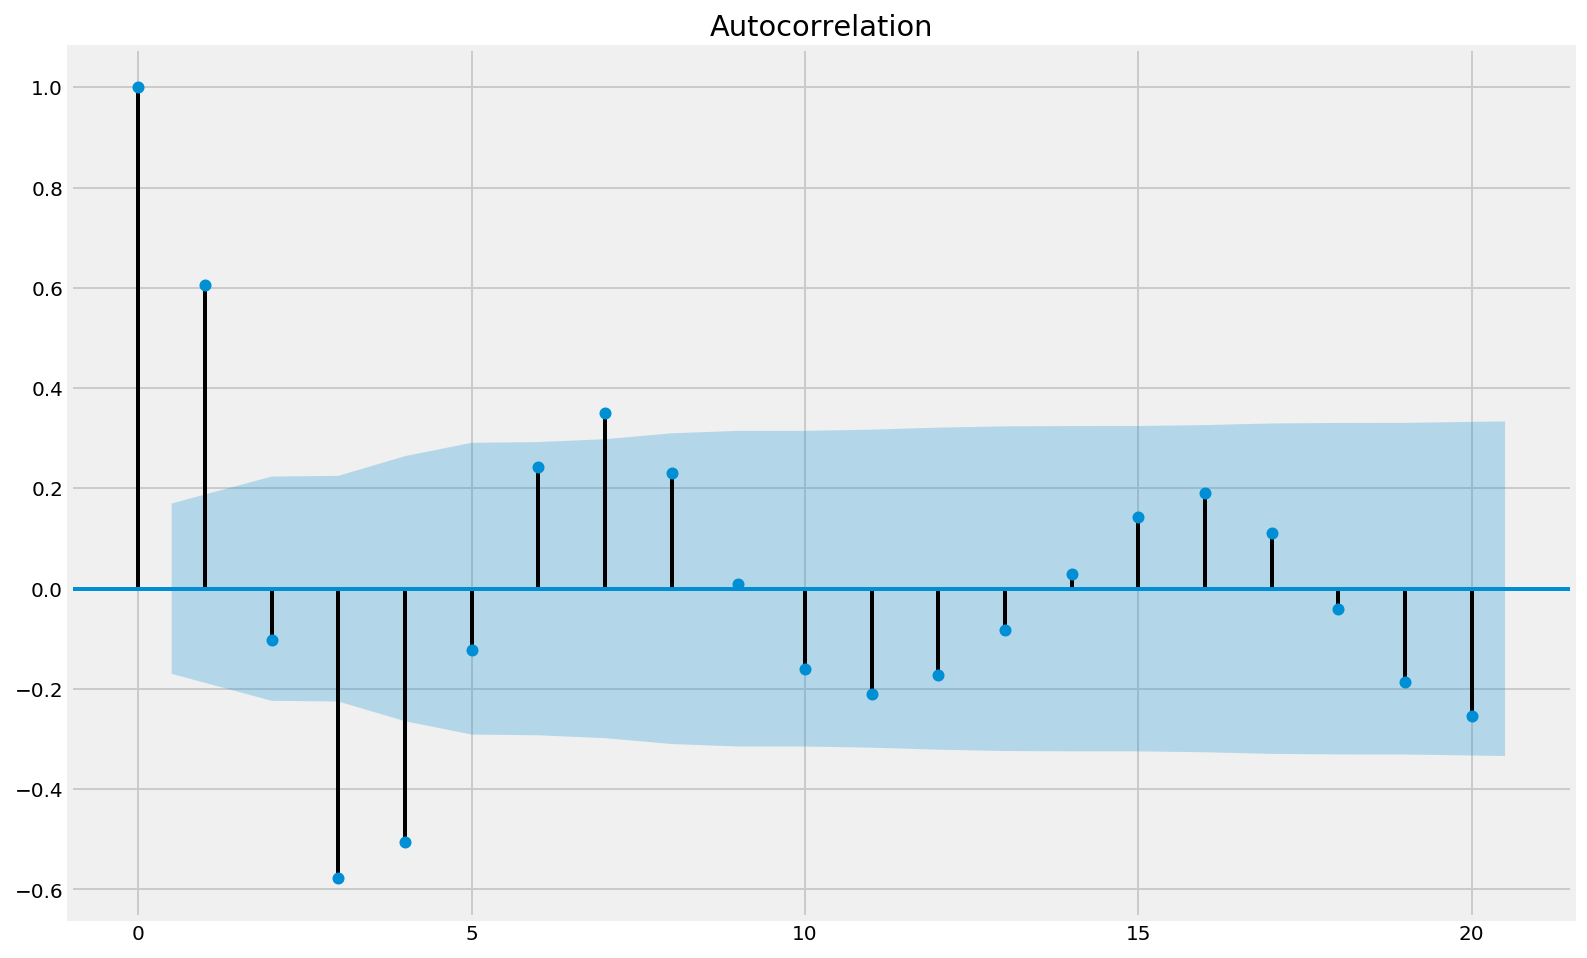

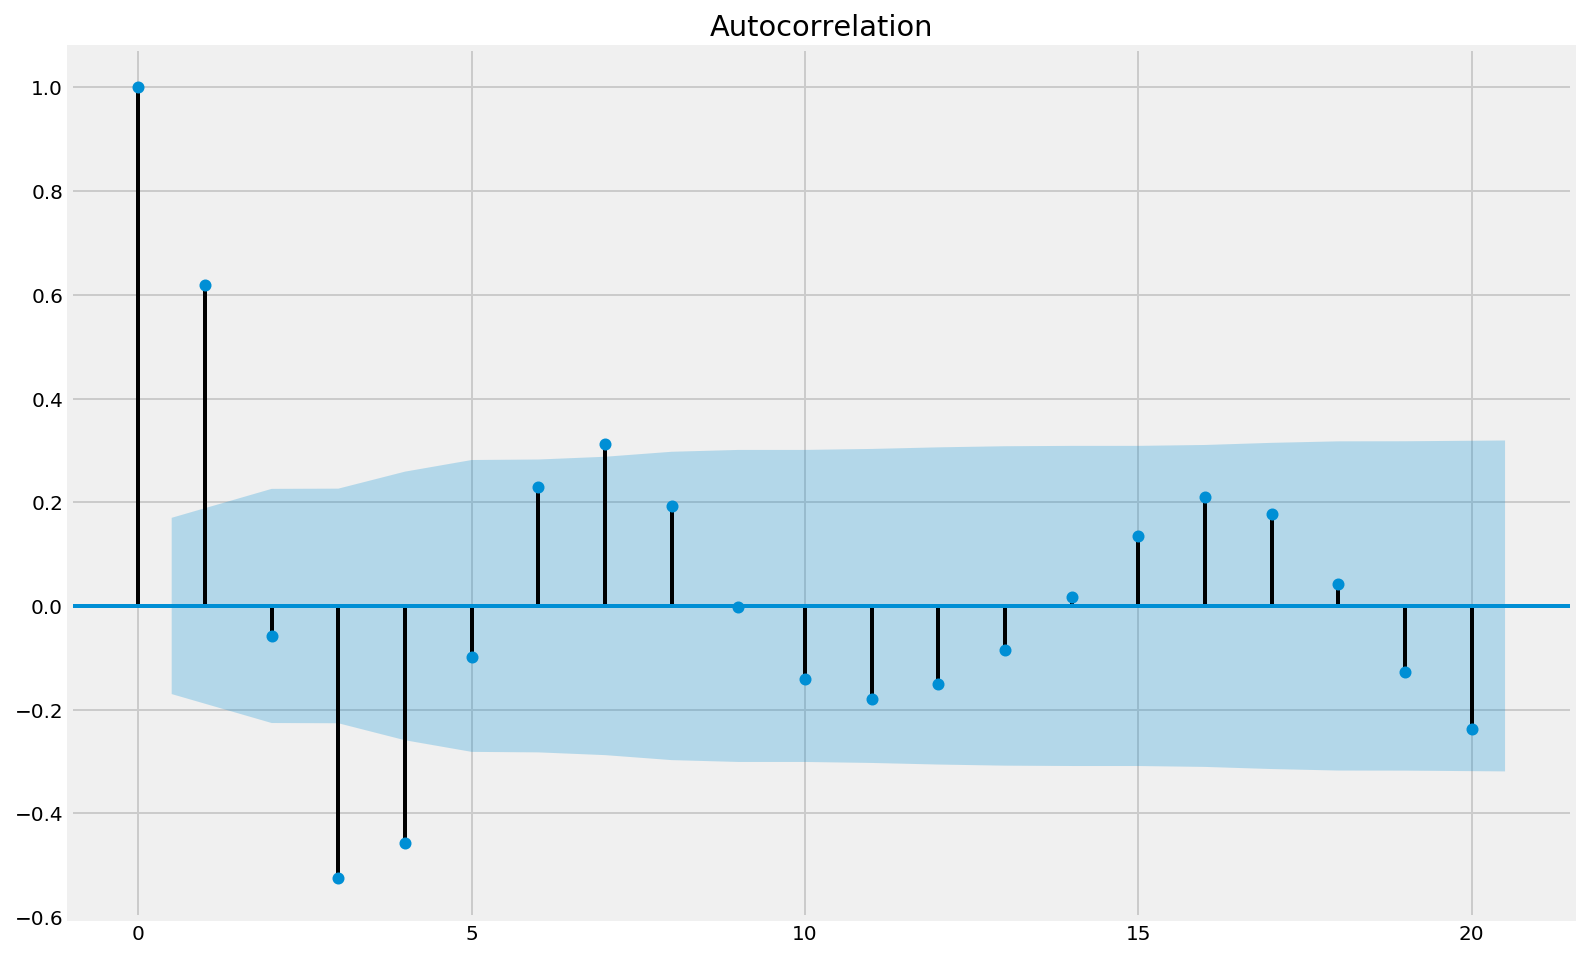

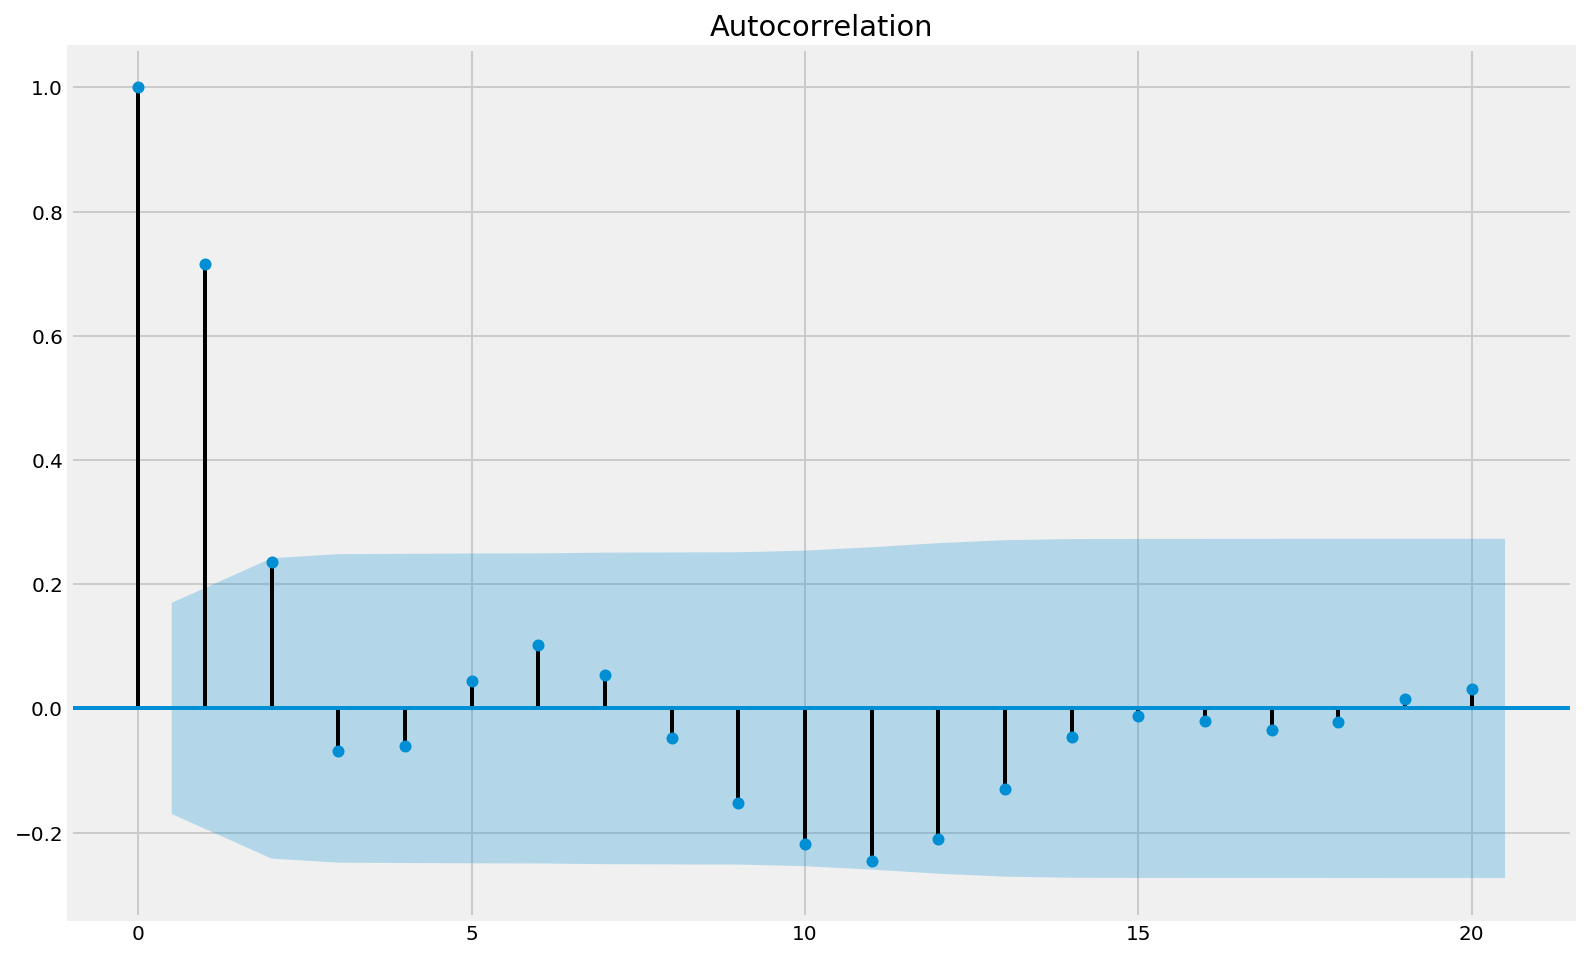

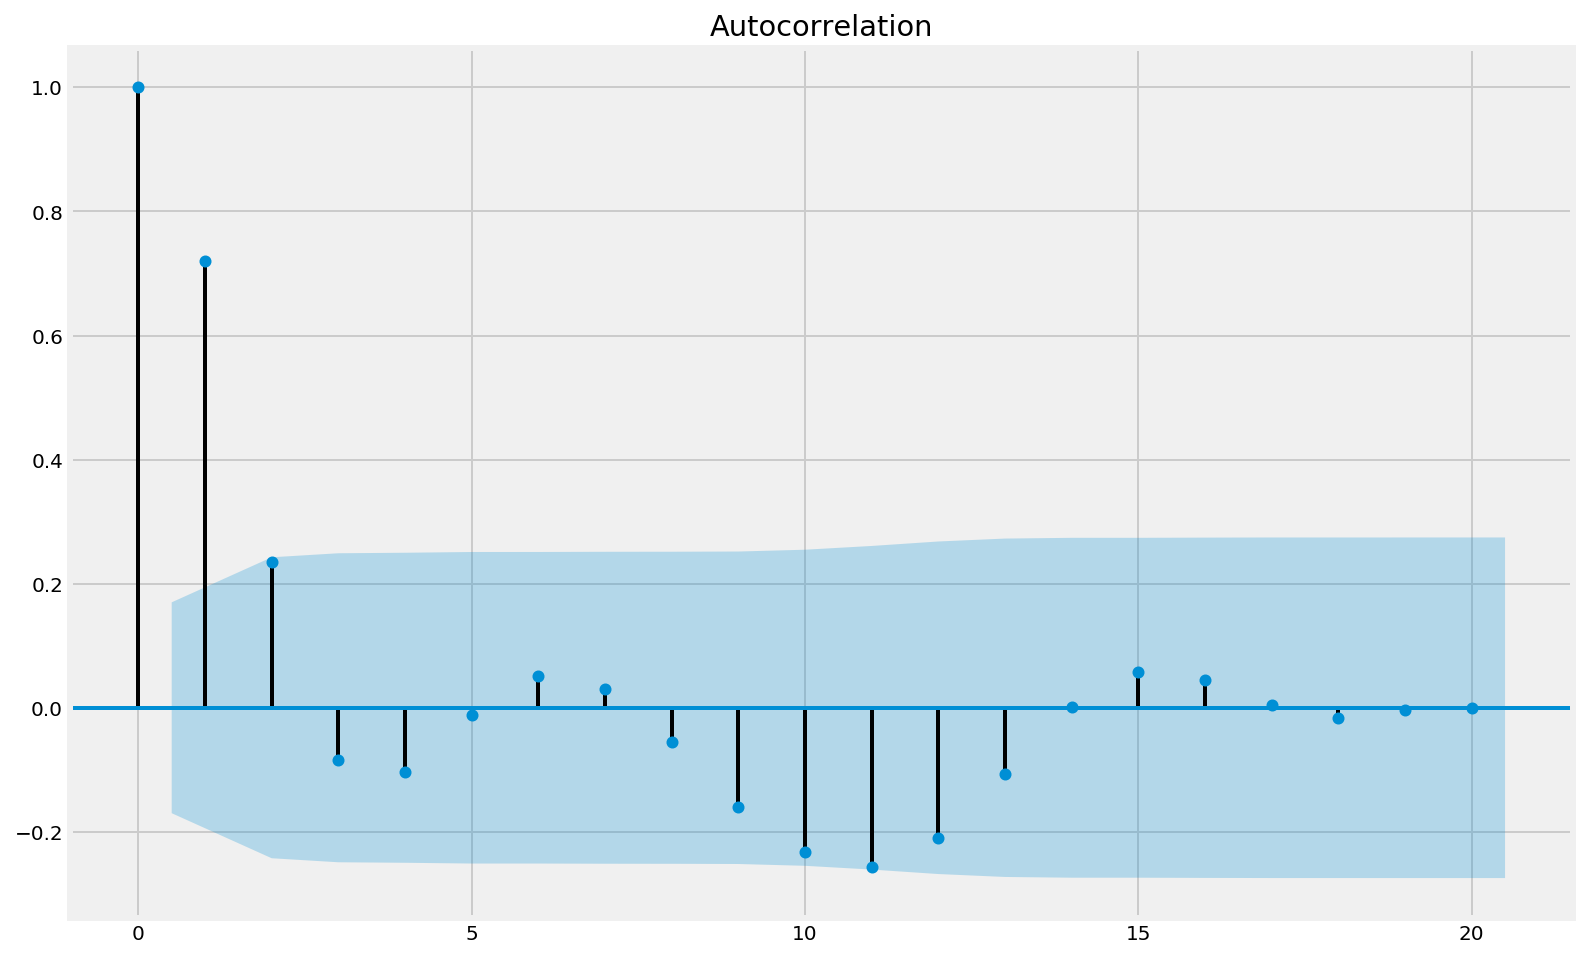

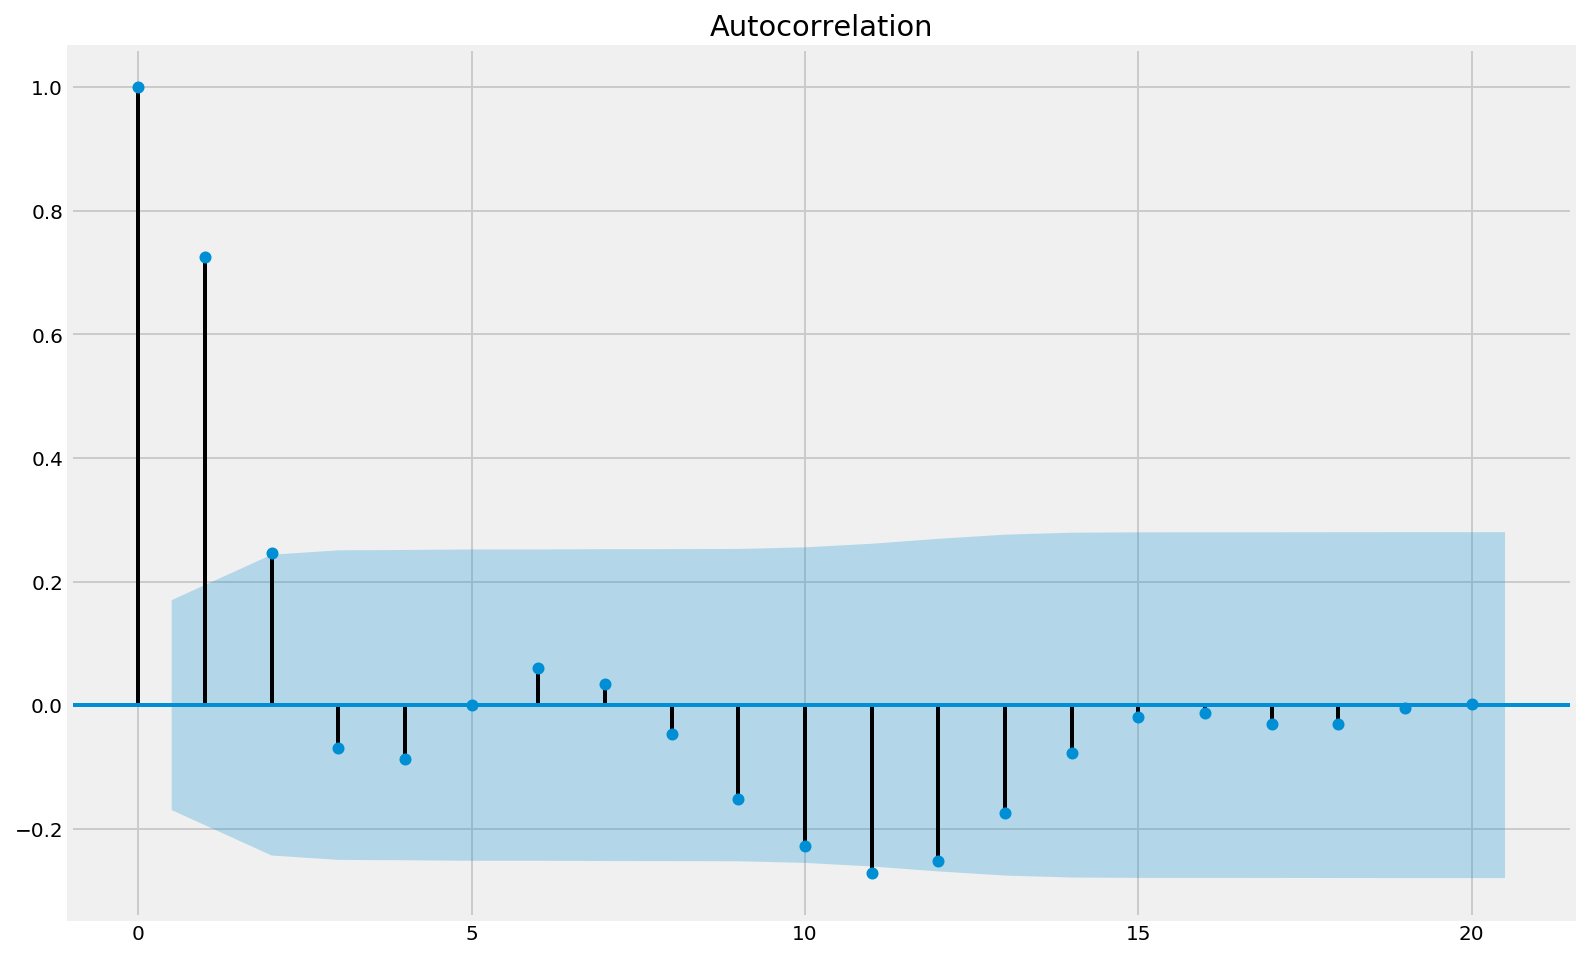

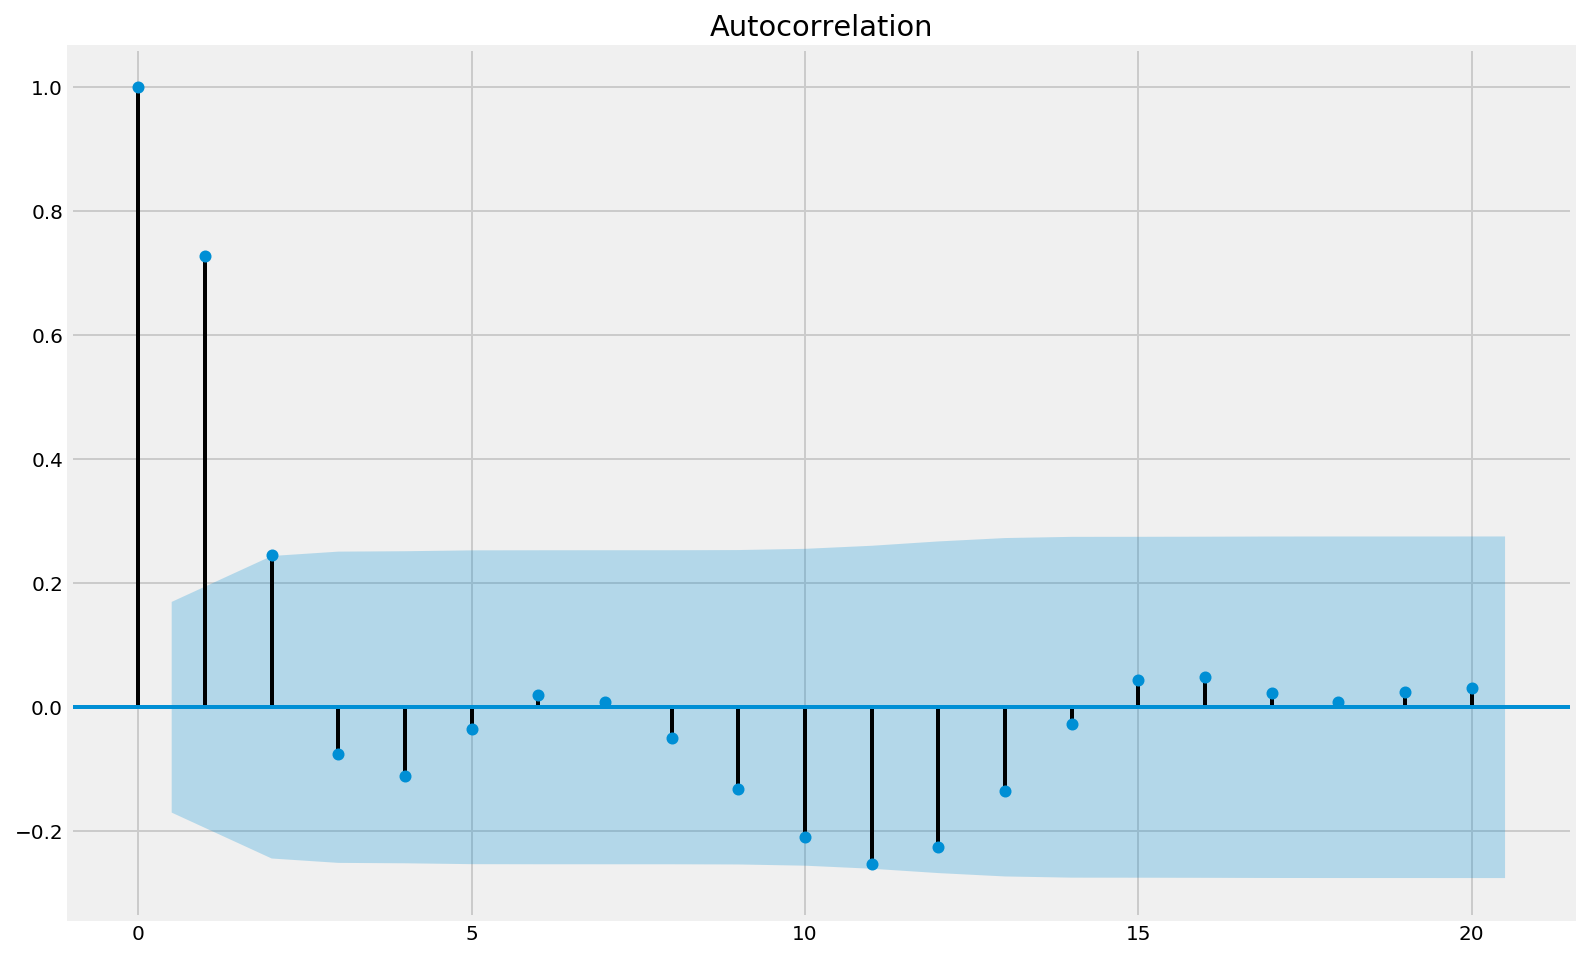

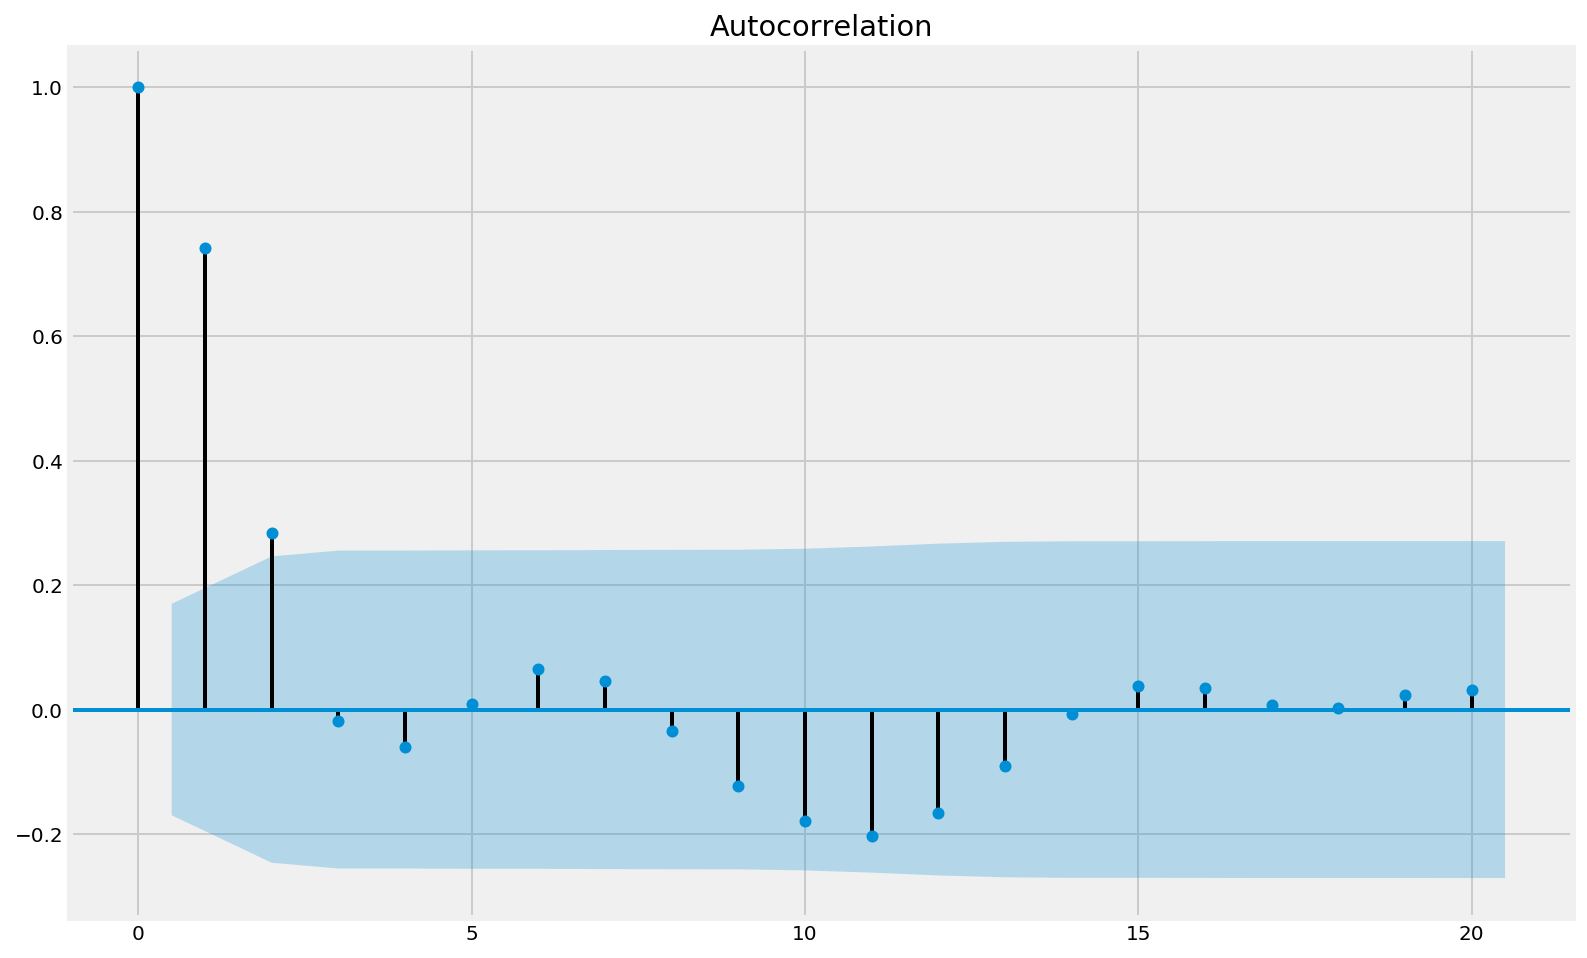

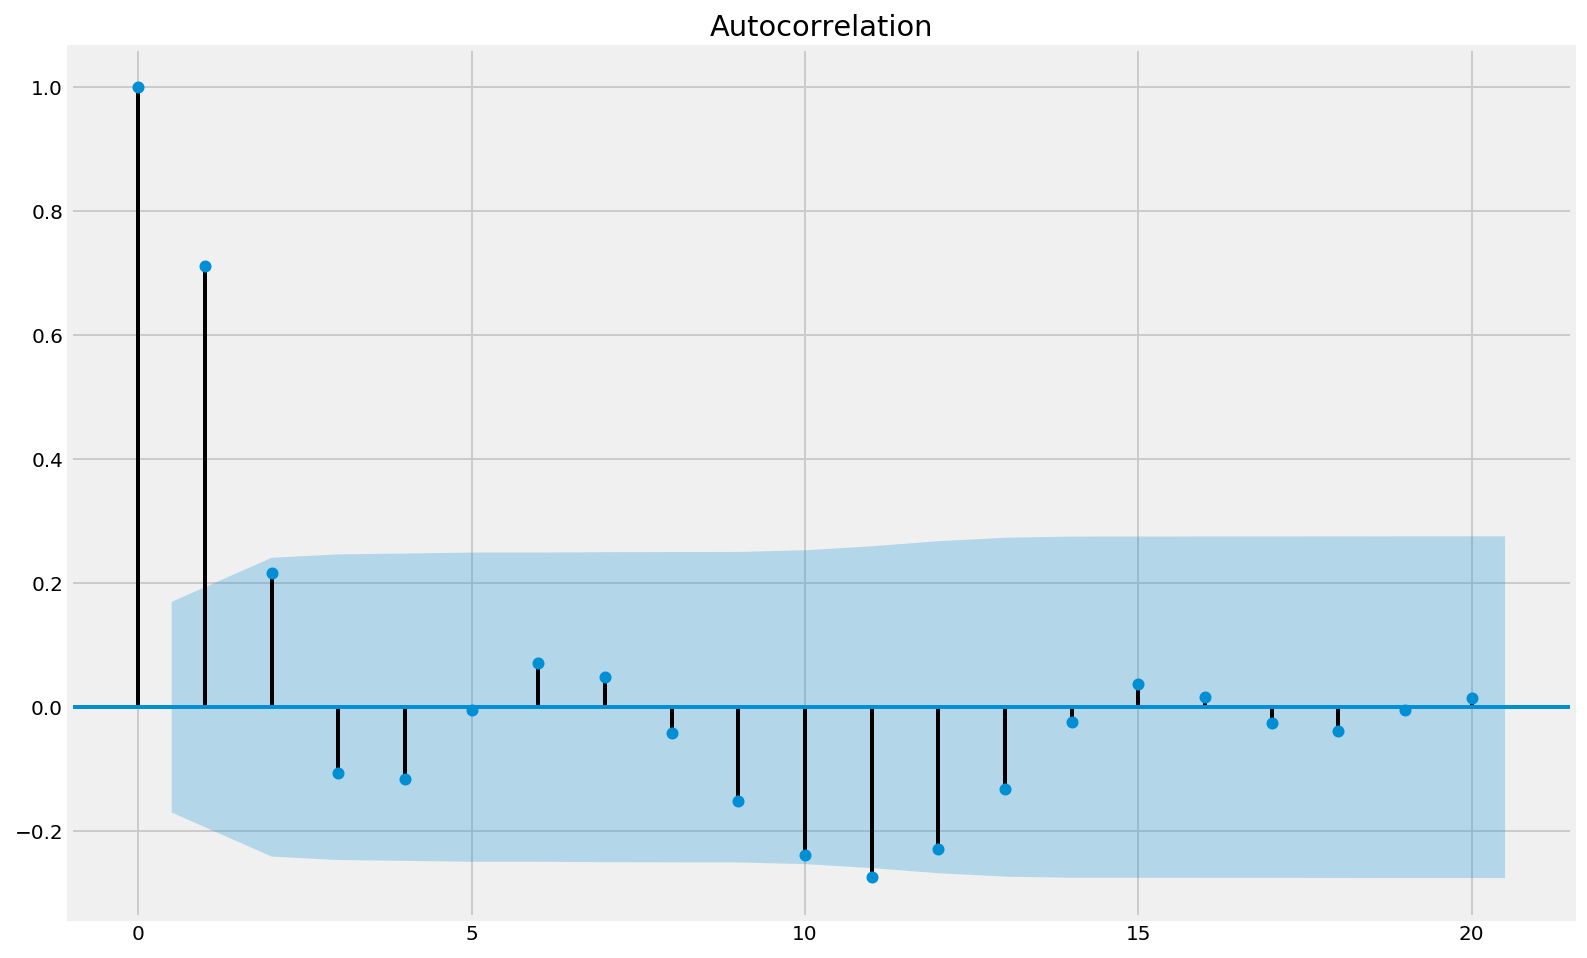

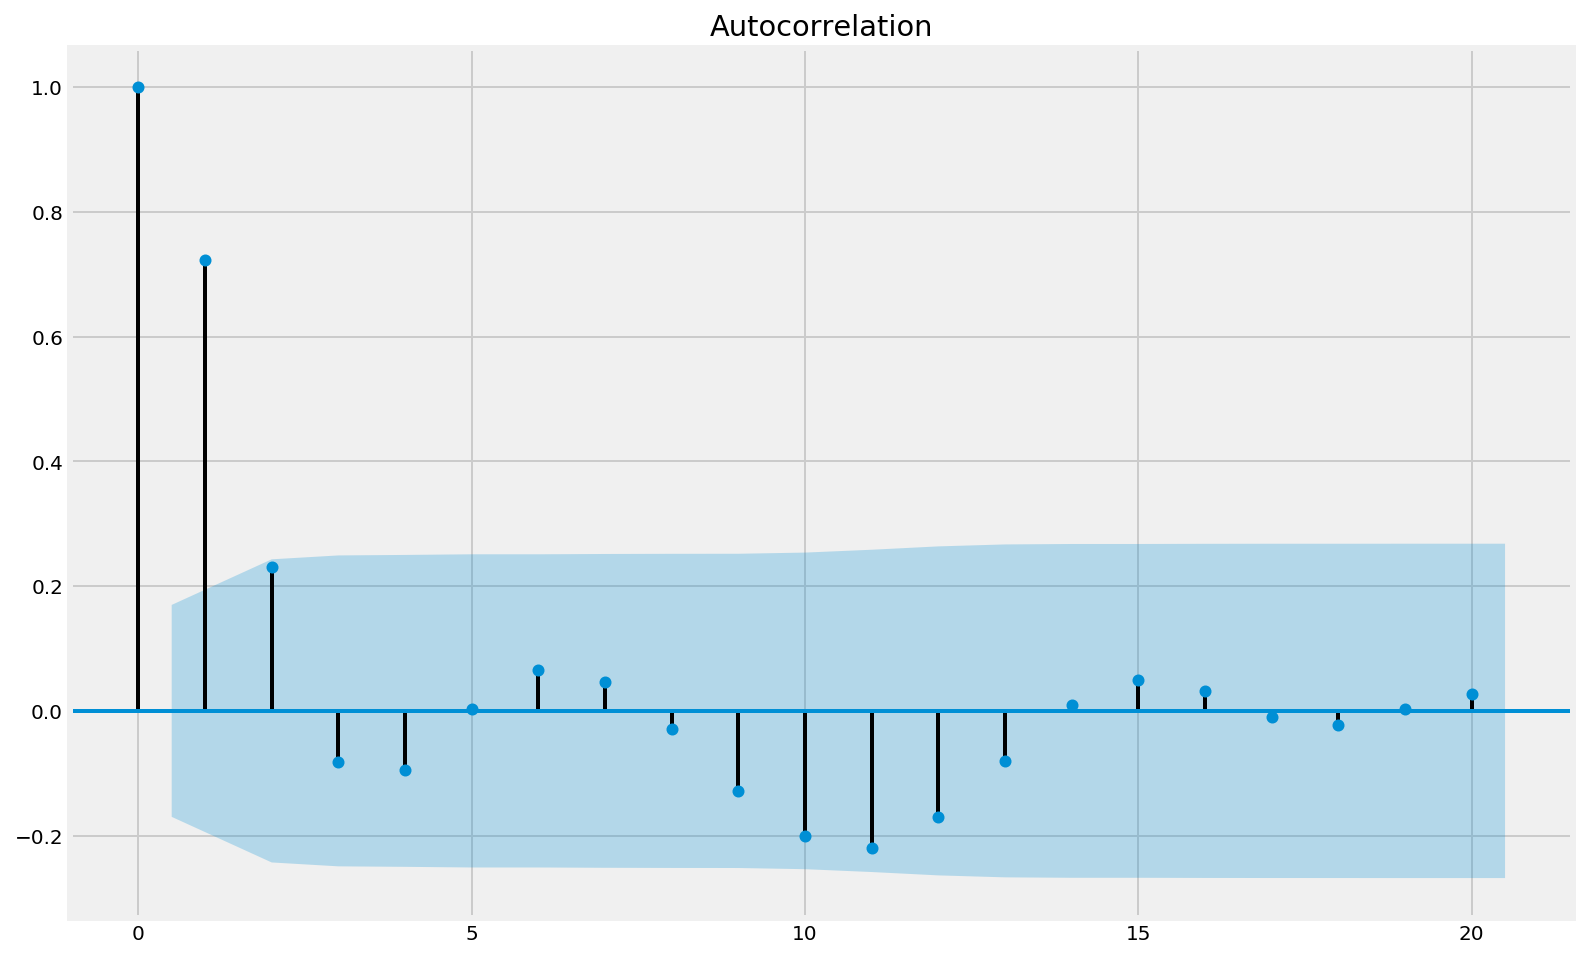

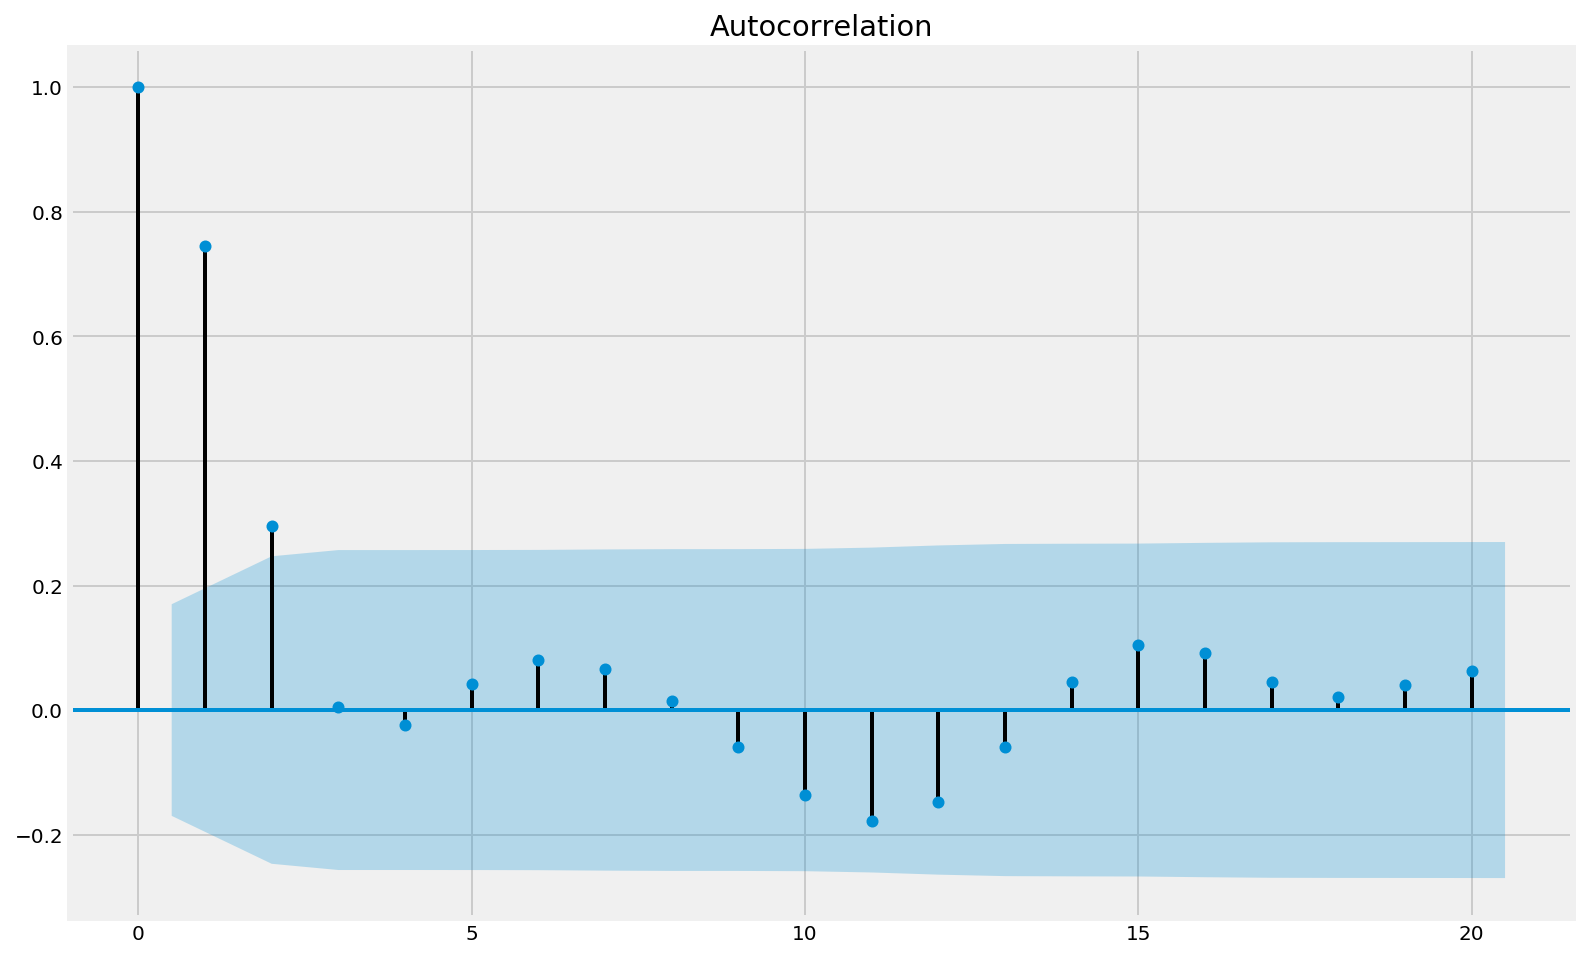

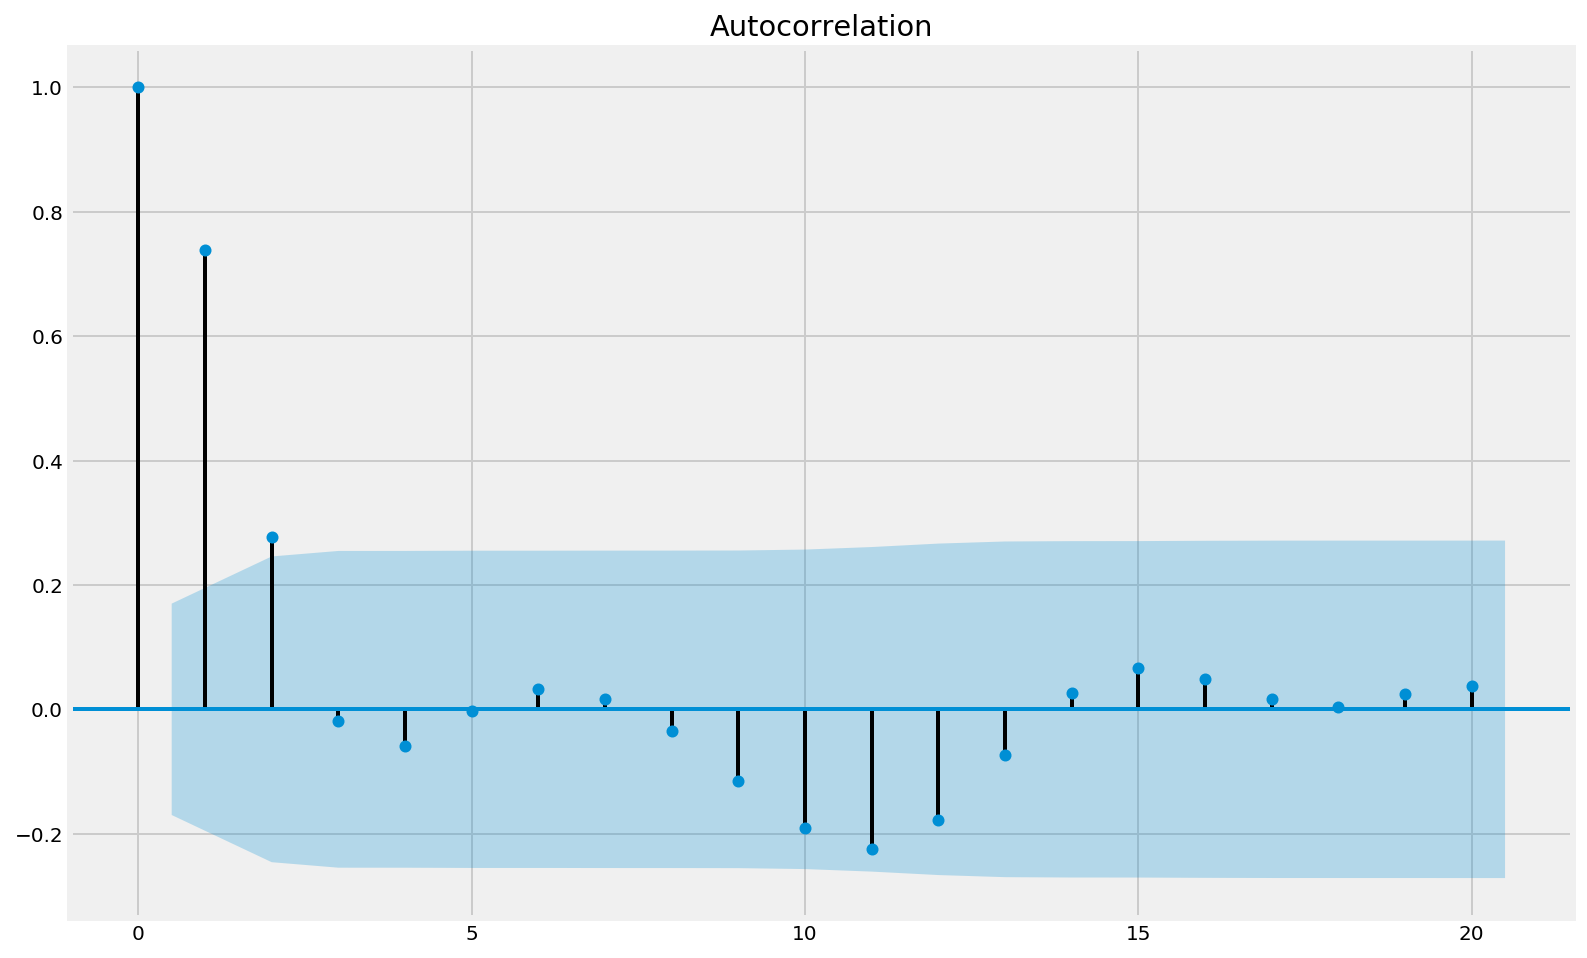

In [6]:
mpl.rc("figure", figsize=(12,8))
for skuId in dataset[dataset.scope == 1].sort_values(by='cluster').sku.unique():
    plot_acf(dataset[dataset.sku == skuId].target, lags=20)
    plt.show()

# Random Forest on Time Series
We try to apply random forest using the features at our disposal. We build a new DataFrame containing the sales, price, exposed, and promo of the last N weeks. We use this new DataFrame to predict the sale of the current week.

To check if the model is robust enough, since we have only 133 weeks of data for each sku, we perform **Cross Validation** using **10-folds**.

**get_series**: build DataFrame with previous lagged variables

In [7]:
def get_series(df_original, skuId, lags_sales=3, lags_price=3, lags_exposed=1, lags_promo=1, test_mode=False):
    lags_ps = min(lags_sales, lags_price)
    
    # Build columns based on the number of lags
    cols = np.concatenate((
        np.array(['date']),
        np.array(['sales-{}'.format(x) for x in reversed(range(lags_sales))]),
        np.array(['price-{}'.format(x) for x in reversed(range(lags_price))]),
        np.array(['exposed-{}'.format(x) for x in reversed(range(lags_exposed))]),
        np.array(['promo-{}'.format(x) for x in reversed(range(lags_promo))]),
        np.array(['price-diff-{}'.format(x) for x in reversed(range(lags_price - 1))]),
        np.array(['price-sales-{}'.format(x) for x in reversed(range(lags_ps))]),
        np.array(['target'])
    ))
    
    # Get dataset values based on SKU
    df = df_original[df_original.sku == skuId]
    max_lags = max(lags_sales, lags_price, lags_exposed, lags_promo)
    
    # Build dataframe for test set prediction
    if test_mode:
        # Remove 'target' column
        cols = np.delete(cols, -1)
        
        # Get the last 3 weeks from dataset to use in testset
        from_dataset = df_original[df_original.sku == skuId].drop(columns=['target']).sort_index().tail(max_lags-1)
        
        # Get data to predict from the test set
        df = testset[testset.sku == skuId].append(from_dataset).sort_index()
    
    # Build dataframe from data
    series = pd.DataFrame(columns=cols)
    for dt in range(max_lags, len(df) + 1):
        info = df.iloc[dt - max_lags:dt, :]
        
        # Add 'date', 'sales', and 'price'
        newData = np.concatenate((
            [info.index[len(info.index) - 1]],
            df.iloc[dt - lags_sales:dt, :].sales.array,
            df.iloc[dt - lags_price:dt, :].price.array,
            df.iloc[dt - lags_exposed:dt, :].exposed.array,
            df.iloc[dt - lags_promo:dt, :].promo.array,
            df.iloc[dt - lags_price:dt, :].price.diff().dropna().array,
            (df.iloc[dt - lags_ps:dt, :].sales / df.iloc[dt - lags_ps:dt, :].price).array,
        ))
            
        # Add the target only if we are training the model    
        if not(test_mode):    
            newData = np.concatenate((
                newData,
                [info.target[len(info.target) - 1]],
            ))
        
        # Append new data to final dataframe
        newDf = pd.DataFrame([newData], columns=cols)            
        series = series.append(newDf, ignore_index=True)
        
    # Set 'date' as index
    series = series.set_index('date')
    return series

The **get_series** functions builds a new dataframe with the previous weeks information for each of the features.

In [8]:
get_series(dataset, skuId=144, lags_sales=3, lags_price=3, lags_exposed=1, lags_promo=1, test_mode=False)

,sales-2,sales-1,sales-0,price-2,price-1,price-0,exposed-0,promo-0,price-diff-1,price-diff-0,price-sales-2,price-sales-1,price-sales-0,target
date,,,,,,,,,,,,,,
2016-12-24,51320.0,51320.0,66431.0,2.18,2.00,2.05,17.0,100.000000,-0.18,0.05,23541.284404,25660.000000,32405.365854,57001.0
2016-12-31,51320.0,66431.0,57001.0,2.00,2.05,3.00,2.0,100.000000,0.05,0.95,25660.000000,32405.365854,19000.333333,15052.0
2017-01-07,66431.0,57001.0,15052.0,2.05,3.00,2.99,2.0,28.534193,0.95,-0.01,32405.365854,19000.333333,5034.113712,22016.0
2017-01-14,57001.0,15052.0,22016.0,3.00,2.99,3.00,0.0,6.251590,-0.01,0.01,19000.333333,5034.113712,7338.666667,21762.0
2017-01-21,15052.0,22016.0,21762.0,2.99,3.00,2.19,0.0,0.000000,0.01,-0.81,5034.113712,7338.666667,9936.986301,46125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-25,15246.0,84950.0,121612.0,1.89,1.75,1.75,52.0,98.137327,-0.14,0.00,8066.666667,48542.857143,69492.571429,118522.0
2019-06-01,84950.0,121612.0,118522.0,1.75,1.75,2.08,59.0,99.523619,0.00,0.33,48542.857143,69492.571429,56981.730769,53158.0
2019-06-08,121612.0,118522.0,53158.0,1.75,2.08,3.49,6.0,93.695179,0.33,1.41,69492.571429,56981.730769,15231.518625,16493.0


In [9]:
def k_cross_validation(df, K_fold_split=10, model=RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=1), target_variable='target'):
    print("Working on {}".format(model))
    input_variables = df.columns[df.columns != target_variable]

    X = df[input_variables]
    y = df[target_variable]
    
    # Remove date
    X.reset_index(inplace=True)
    y = y.reset_index()
    
    # K-Fold splits
    kf = KFold(n_splits=K_fold_split, random_state=10)
    kf.get_n_splits(X)
    
    mape_count = []
    feat_importance = pd.DataFrame(columns=input_variables)
    
    hasFeatImp = True
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = X_train.set_index('date')
        y_train = y_train.set_index('date')
        X_test = X_test.set_index('date')
        y_test = y_test.set_index('date')
        
        # Fit the model
        m_res = model.fit(X_train, y_train)
        print("Fitting...")
        if hasattr(m_res, 'feature_importances_'):
            feat_importance = feat_importance.append(pd.Series(m_res.feature_importances_, index=input_variables), ignore_index=True)
        elif hasattr(m_res, 'coef_'):
            feat_importance = feat_importance.append(pd.Series(m_res.coef_, index=input_variables), ignore_index=True)
        else:
            hasFeatImp = False
            
        # Predict
        yp = model.predict(X_test)
        
        if hasattr(model, 'oob_score_'):
            print(model.oob_score_)
        
        df_result_test = pd.DataFrame(y_test)
        df_result_test['predicted'] = yp
        
        mape_val = mean_absolute_percentage_error(df_result_test.target, df_result_test.predicted)
        
        mape_count.append(mape_val)
    
    m_series = pd.Series(mape_count)
    if hasFeatImp:
        feat_importance.mean().sort_values().plot.bar(x=0, y=1, rot=0)
        plt.show()
        print(feat_importance.mean())
    return m_series

We use the **Random Forest Regression** on the new dataframe. Based on our previous autocorrelation analysis, we select up to 3 steps in the past of sales.

Sales lag = 1, Price lag = 1, Promo lag = 1, Exposed lag = 1
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9548686179971557
Fitting...
0.9596324400441286
Fitting...
0.95541032206926
Fitting...
0.9590277997799962
Fitting...
0.9738463548721539
Fitting...
0.9577306377990502
Fitting...
0.959025422256076
Fitting...
0.9571919758279057
Fitting...
0.933949700966448
Fitting...
0.9465932132060169


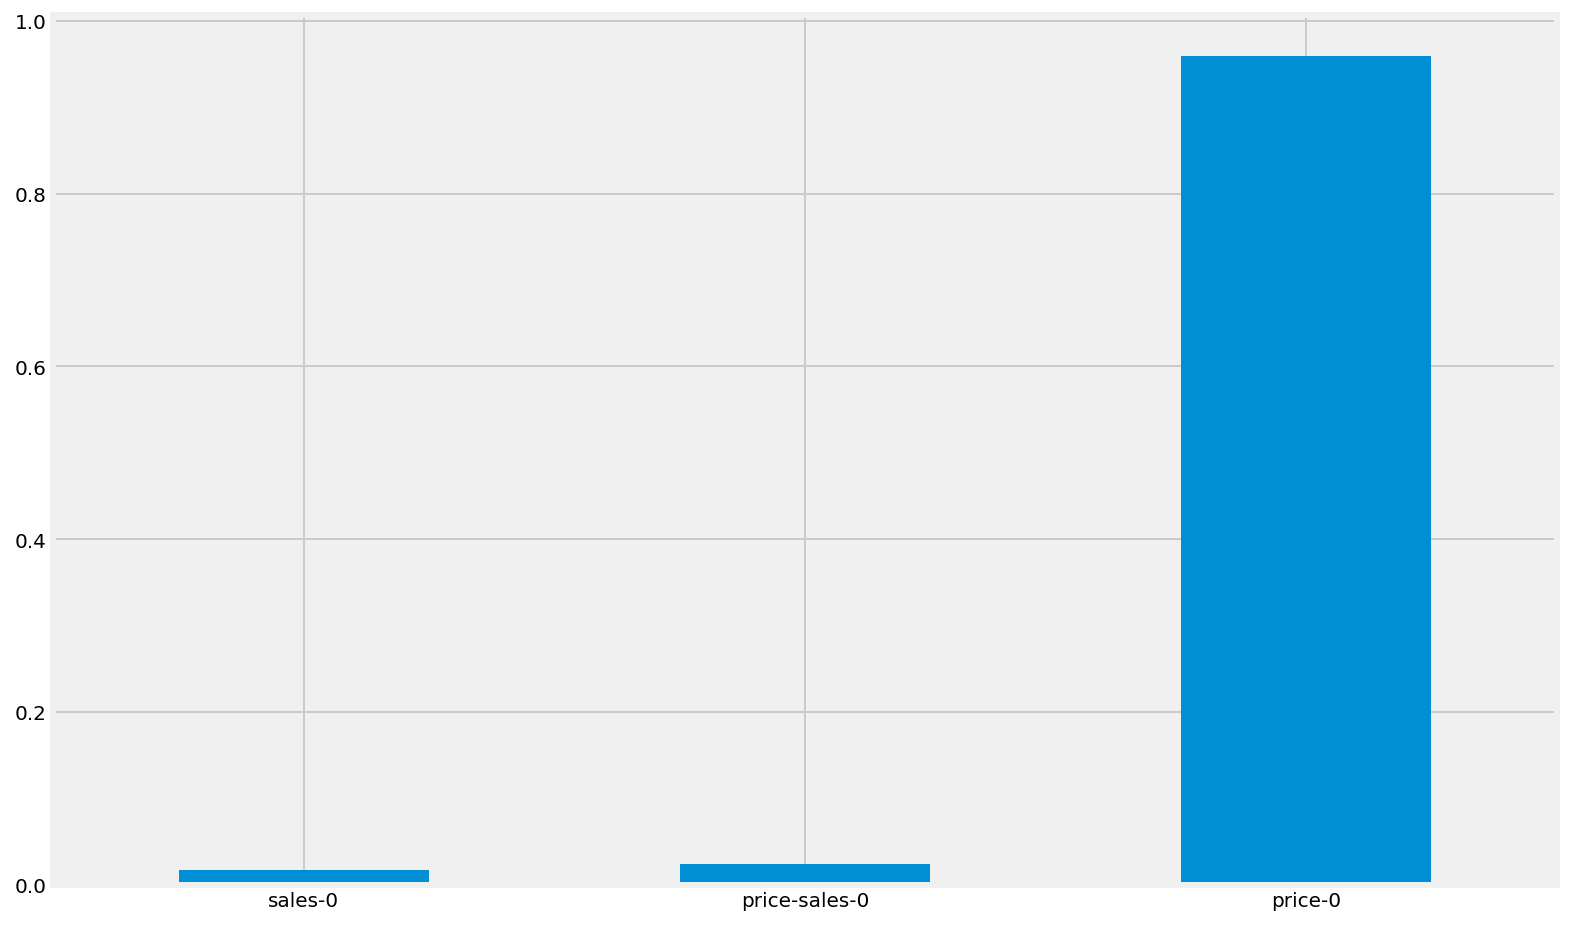

sales-0          0.016745
price-0          0.959204
price-sales-0    0.024051
dtype: float64
14.04219454061376
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.925106438424171
Fitting...
0.9356240222368966
Fitting...
0.9377816680950475
Fitting...
0.9243364442028082
Fitting...
0.9204838260109941
Fitting...
0.9248747727877188
Fitting...
0.9192699519174612
Fitting...
0.9192453527921427
Fitting...
0.9222310608792389
Fitting...
0.9238590478052507


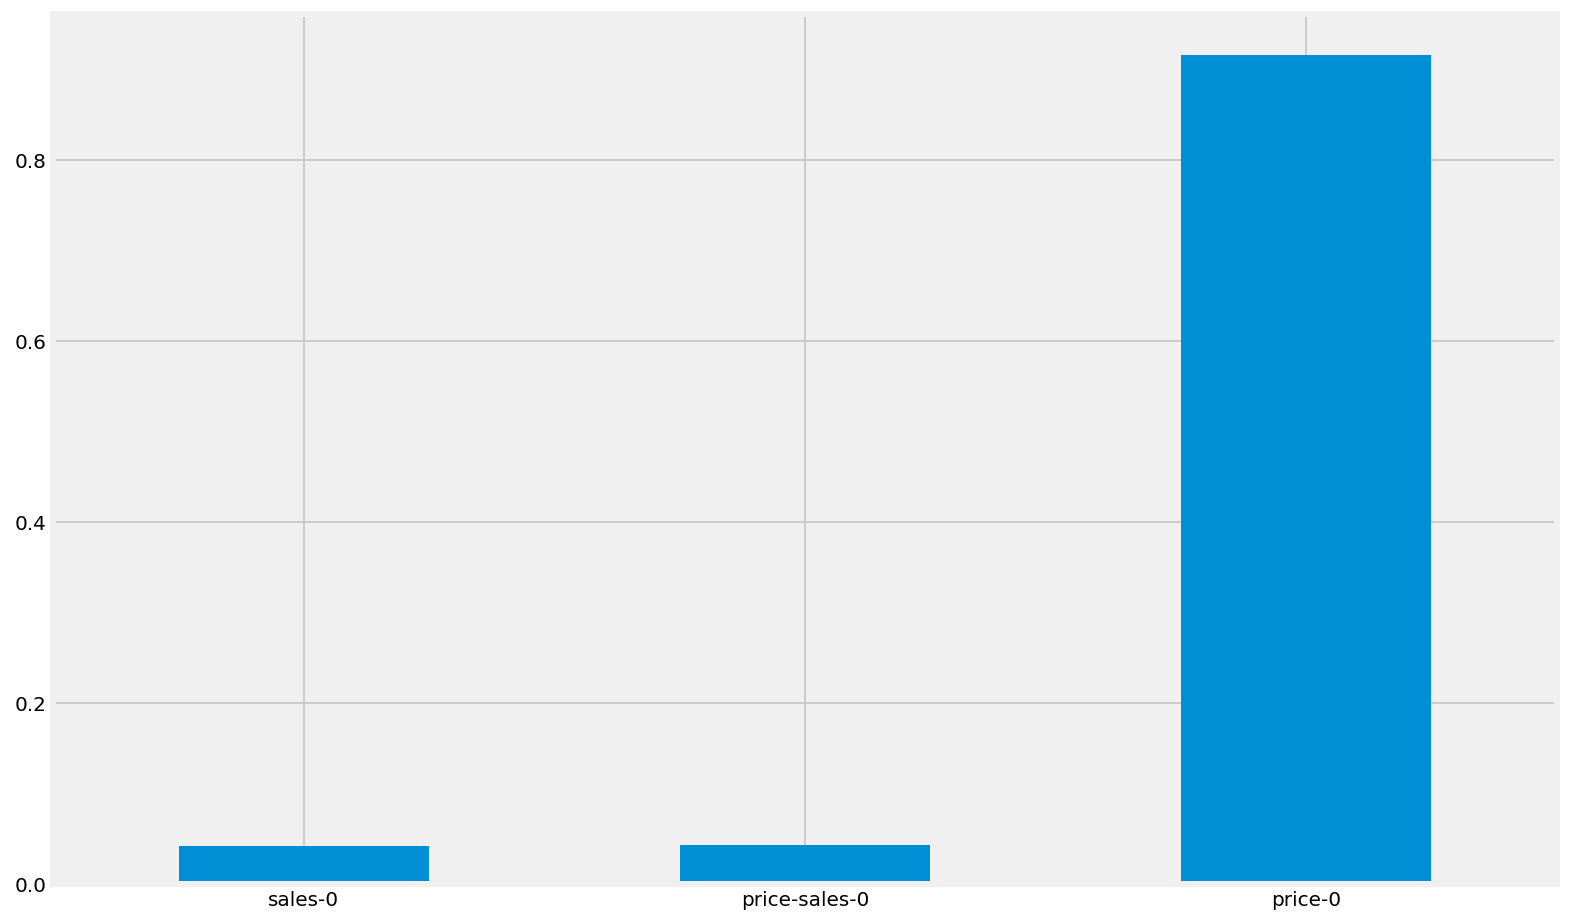

sales-0          0.042002
price-0          0.915320
price-sales-0    0.042678
dtype: float64
11.300598569310722
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9392514884271
Fitting...
0.9396434560831789
Fitting...
0.9587626317104002
Fitting...
0.9366025993407974
Fitting...
0.9281524782617163
Fitting...
0.9331648707401975
Fitting...
0.9323002188053371
Fitting...
0.9326939414623494
Fitting...
0.9332308330542551
Fitting...
0.9355958064984807


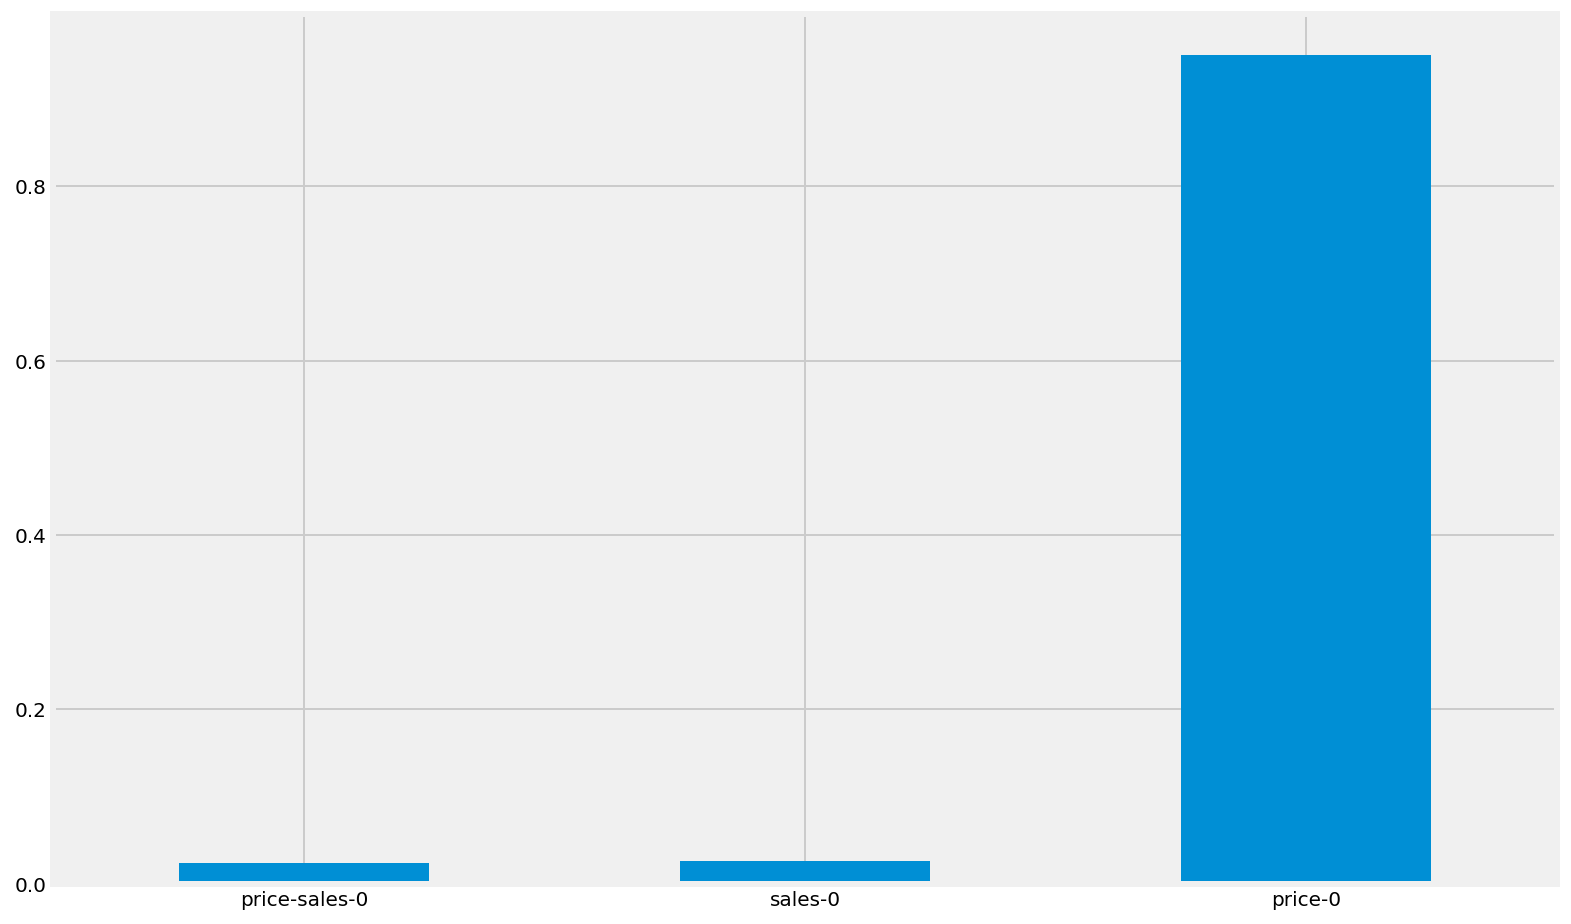

sales-0          0.025750
price-0          0.950338
price-sales-0    0.023912
dtype: float64
14.26506388374373
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9139356506253312
Fitting...
0.9217482924315832
Fitting...
0.9237675921660123
Fitting...
0.91135870609893
Fitting...
0.9131872634564651
Fitting...
0.9157974410197913
Fitting...
0.9072785138273606
Fitting...
0.9002300682339686
Fitting...
0.9046330083038692
Fitting...
0.9055052723292084


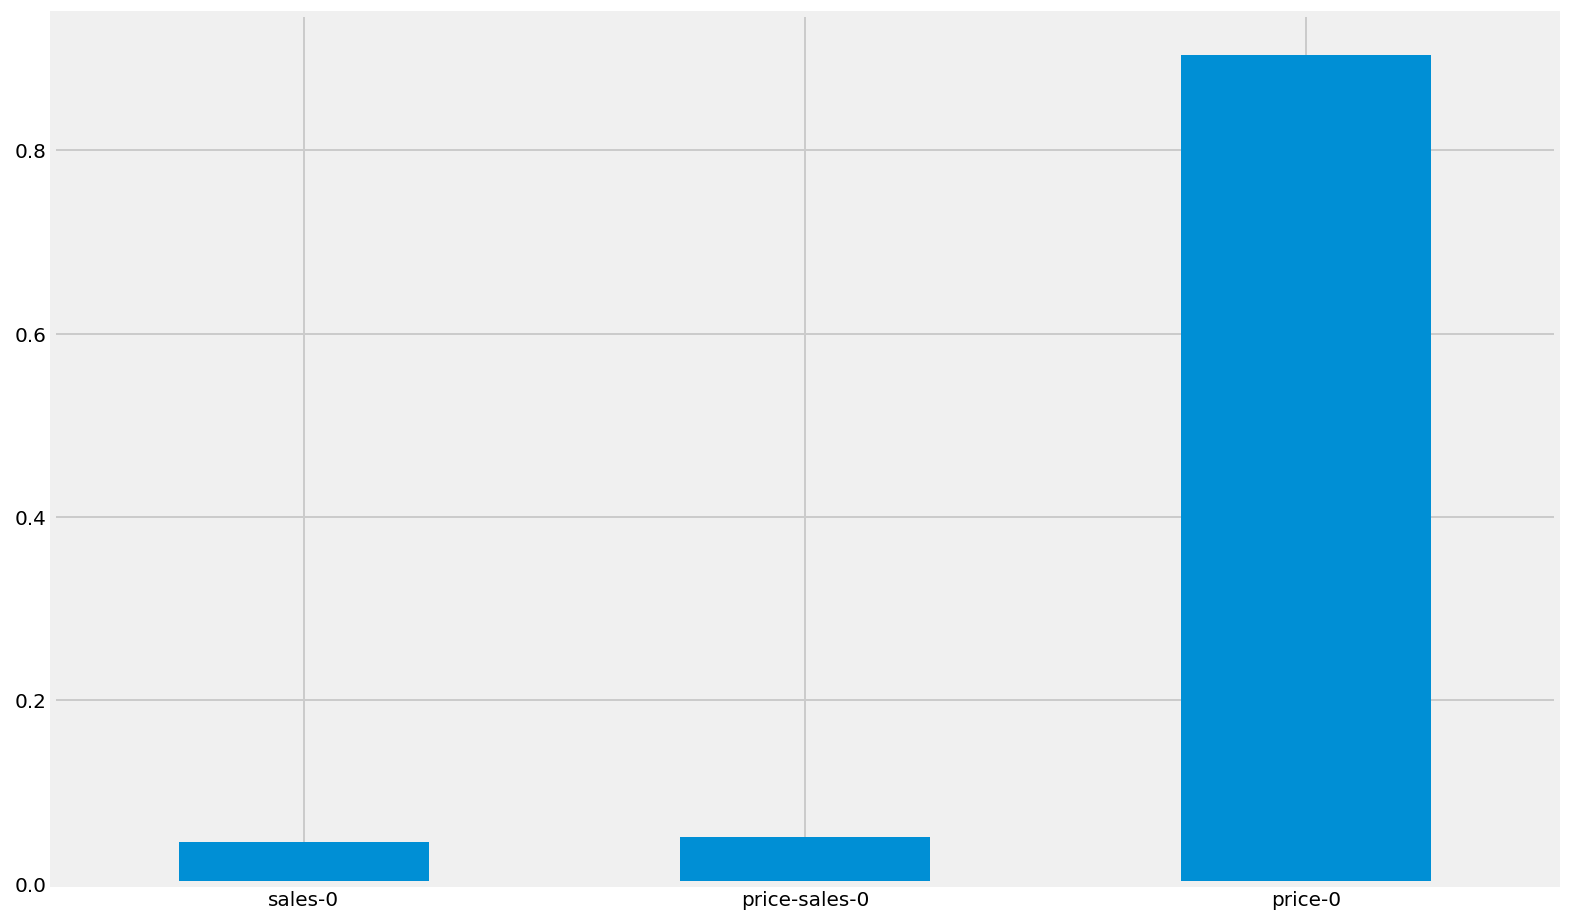

sales-0          0.045231
price-0          0.903643
price-sales-0    0.051127
dtype: float64
10.18549792687528
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9638867115464401
Fitting...
0.9465692381113764
Fitting...
0.946774714056046
Fitting...
0.9447740769664469
Fitting...
0.9609138282598385
Fitting...
0.9461989986630298
Fitting...
0.9485493451993108
Fitting...
0.9474082526674326
Fitting...
0.9297973342020209
Fitting...
0.9353751378906998


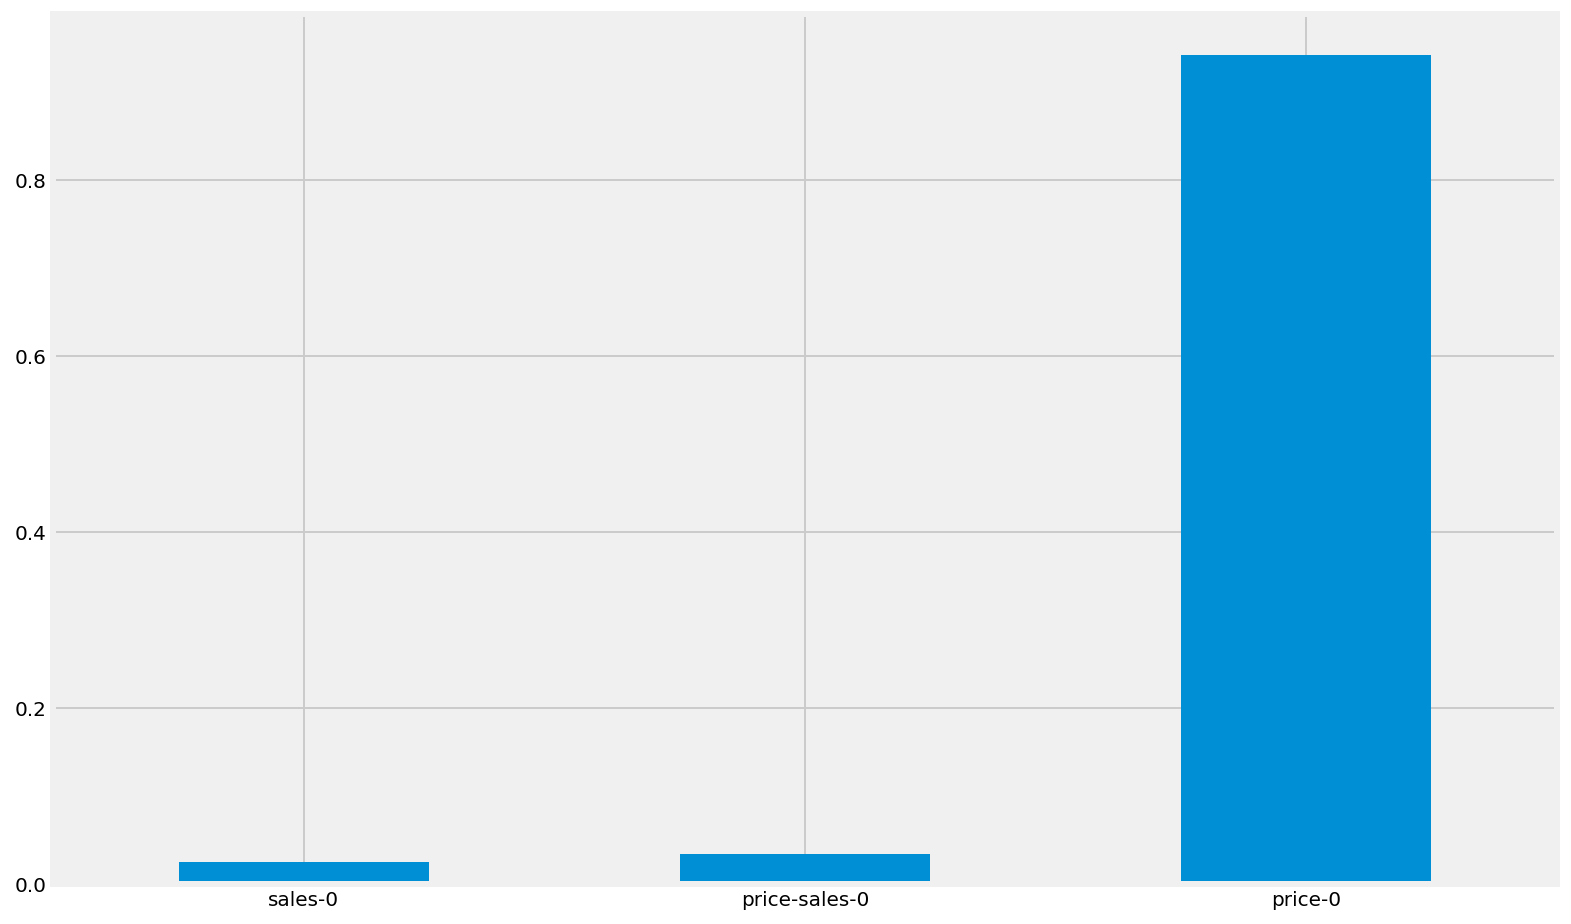

sales-0          0.024106
price-0          0.941689
price-sales-0    0.034205
dtype: float64
13.419874486638893
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9559773790468779
Fitting...
0.9582749495841087
Fitting...
0.9402177703192436
Fitting...
0.958373961015052
Fitting...
0.953106374237192
Fitting...
0.9569419820091177
Fitting...
0.9524020987669201
Fitting...
0.955048943263836
Fitting...
0.9549297701849497
Fitting...
0.9550381277489179


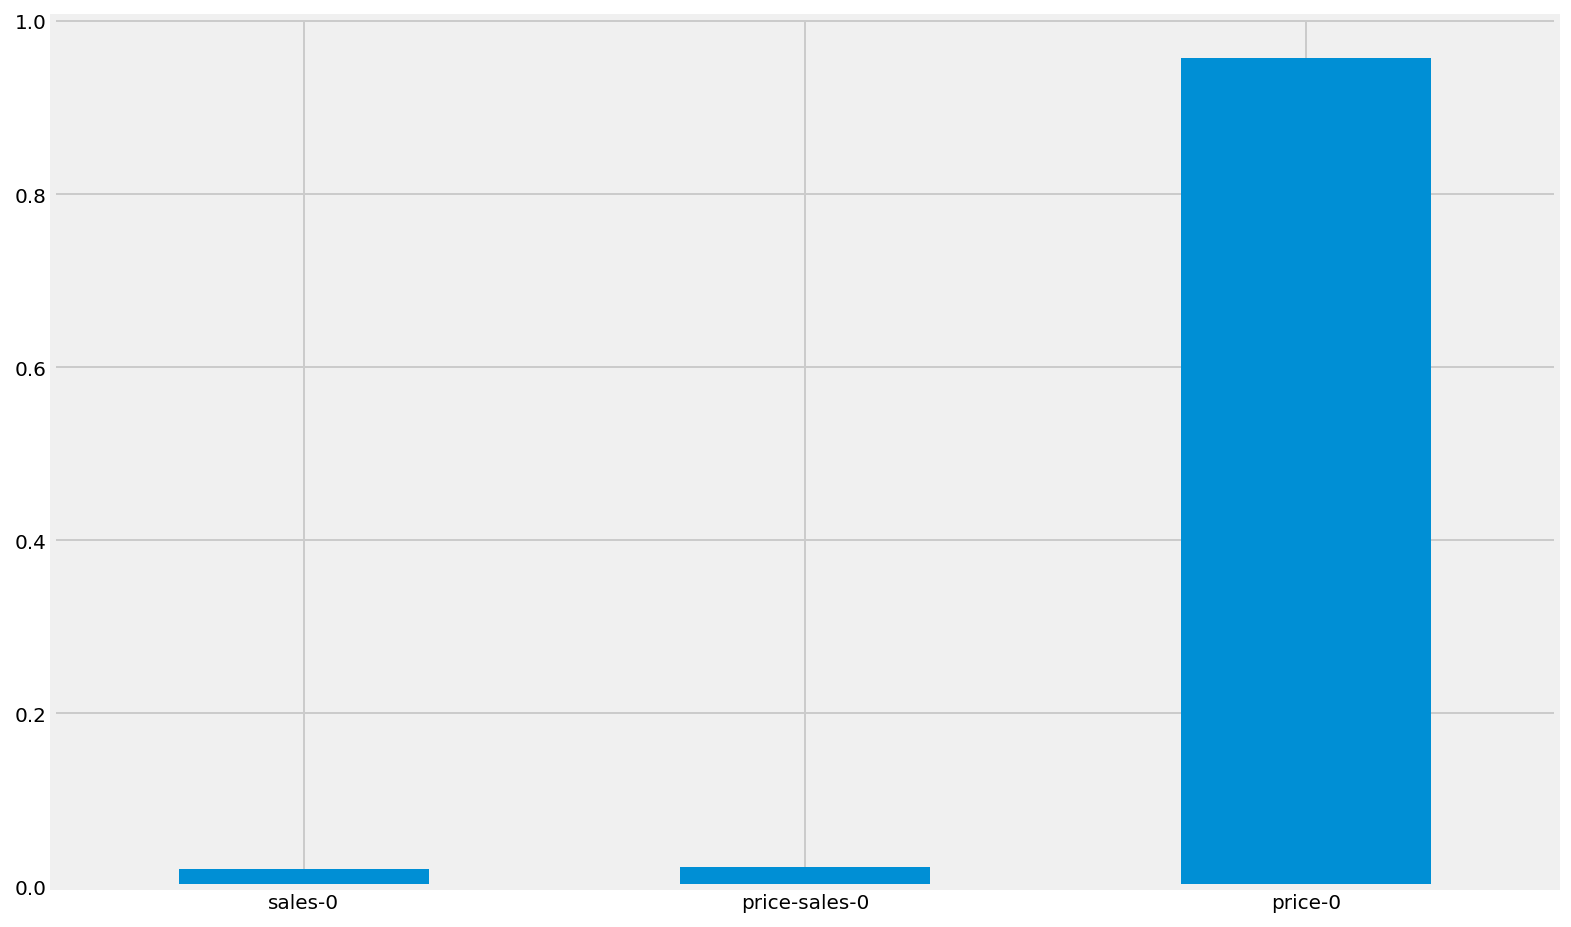

sales-0          0.019978
price-0          0.956963
price-sales-0    0.023060
dtype: float64
9.30650051389235
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9042899946785271
Fitting...
0.9143031372497756
Fitting...
0.904681447779997
Fitting...
0.903558183484564
Fitting...
0.9036351570421617
Fitting...
0.9021660408673239
Fitting...
0.9152304975879672
Fitting...
0.8989790865084016
Fitting...
0.916347179890233
Fitting...
0.910206372929829


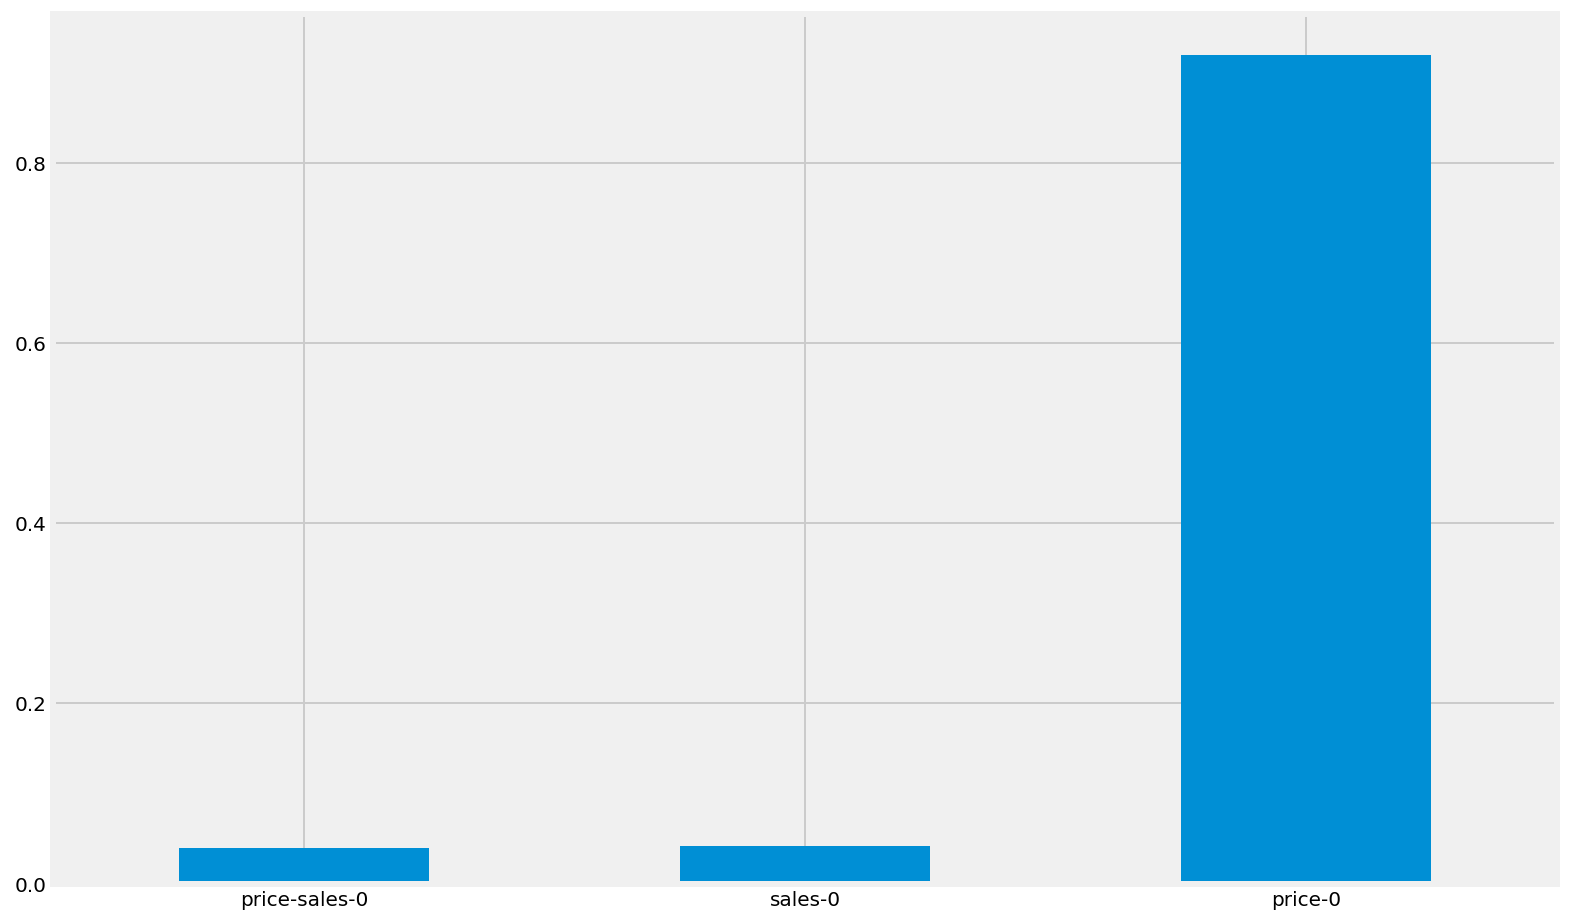

sales-0          0.041279
price-0          0.919377
price-sales-0    0.039344
dtype: float64
13.054520742695875
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9264997987455877
Fitting...
0.9316989496442062
Fitting...
0.9340025634763488
Fitting...
0.9269101150135037
Fitting...
0.9247556457280208
Fitting...
0.9249543570588219
Fitting...
0.9287948635867479
Fitting...
0.9176405719430698
Fitting...
0.9233330056202408
Fitting...
0.9233969580123232


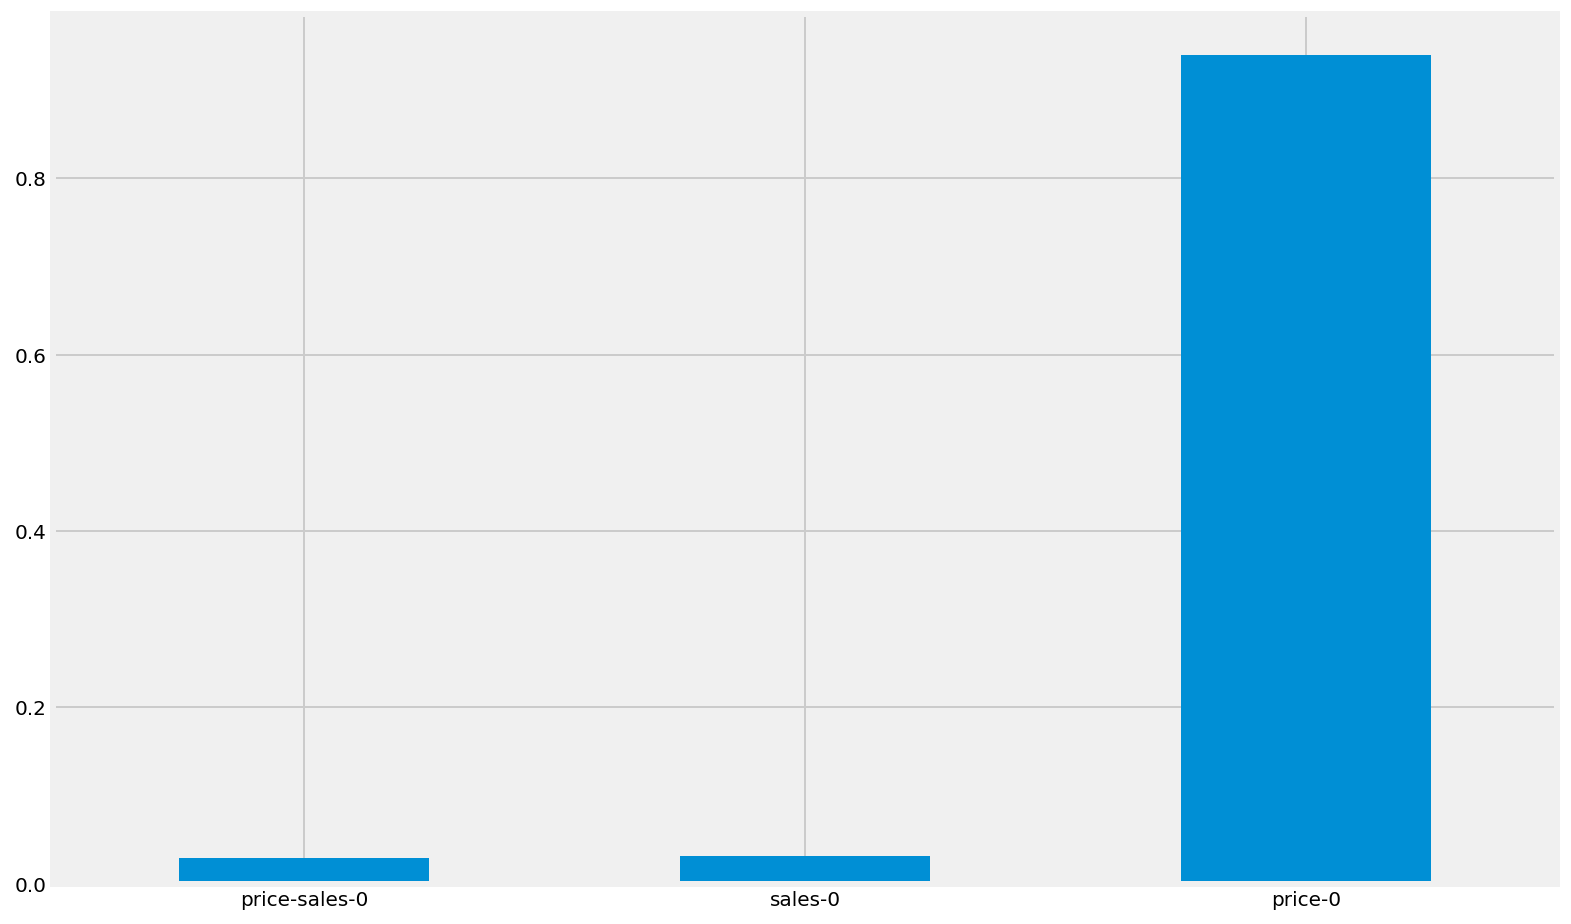

sales-0          0.031647
price-0          0.939538
price-sales-0    0.028815
dtype: float64
12.192709257443997
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9345182771104377
Fitting...
0.927130429642175
Fitting...
0.9251623169667275
Fitting...
0.926045647755568
Fitting...
0.9374494366546323
Fitting...
0.9525523609408975
Fitting...
0.9309173500380326
Fitting...
0.9287465675317007
Fitting...
0.9246244880485204
Fitting...
0.9354719669941132


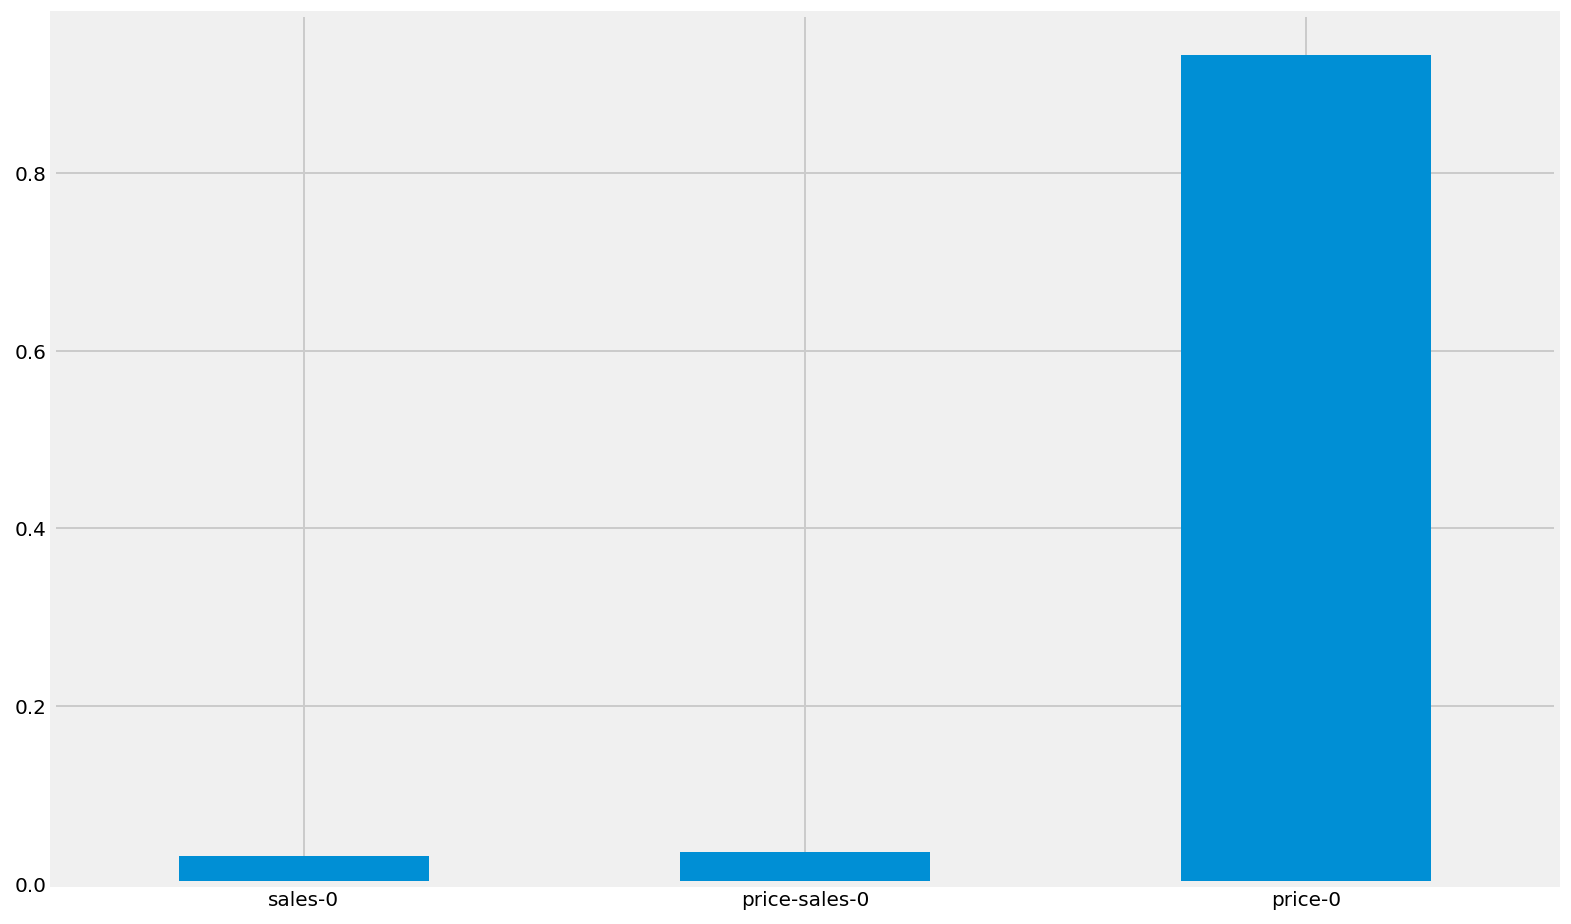

sales-0          0.031009
price-0          0.932900
price-sales-0    0.036090
dtype: float64
10.906169260362784
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9464165369820411
Fitting...
0.9411521482321829
Fitting...
0.9426345522238714
Fitting...
0.9448599543313949
Fitting...
0.9484469024876746
Fitting...
0.9426351300065221
Fitting...
0.9399428223390317
Fitting...
0.9425236112939642
Fitting...
0.9426233727425625
Fitting...
0.9435933332328189


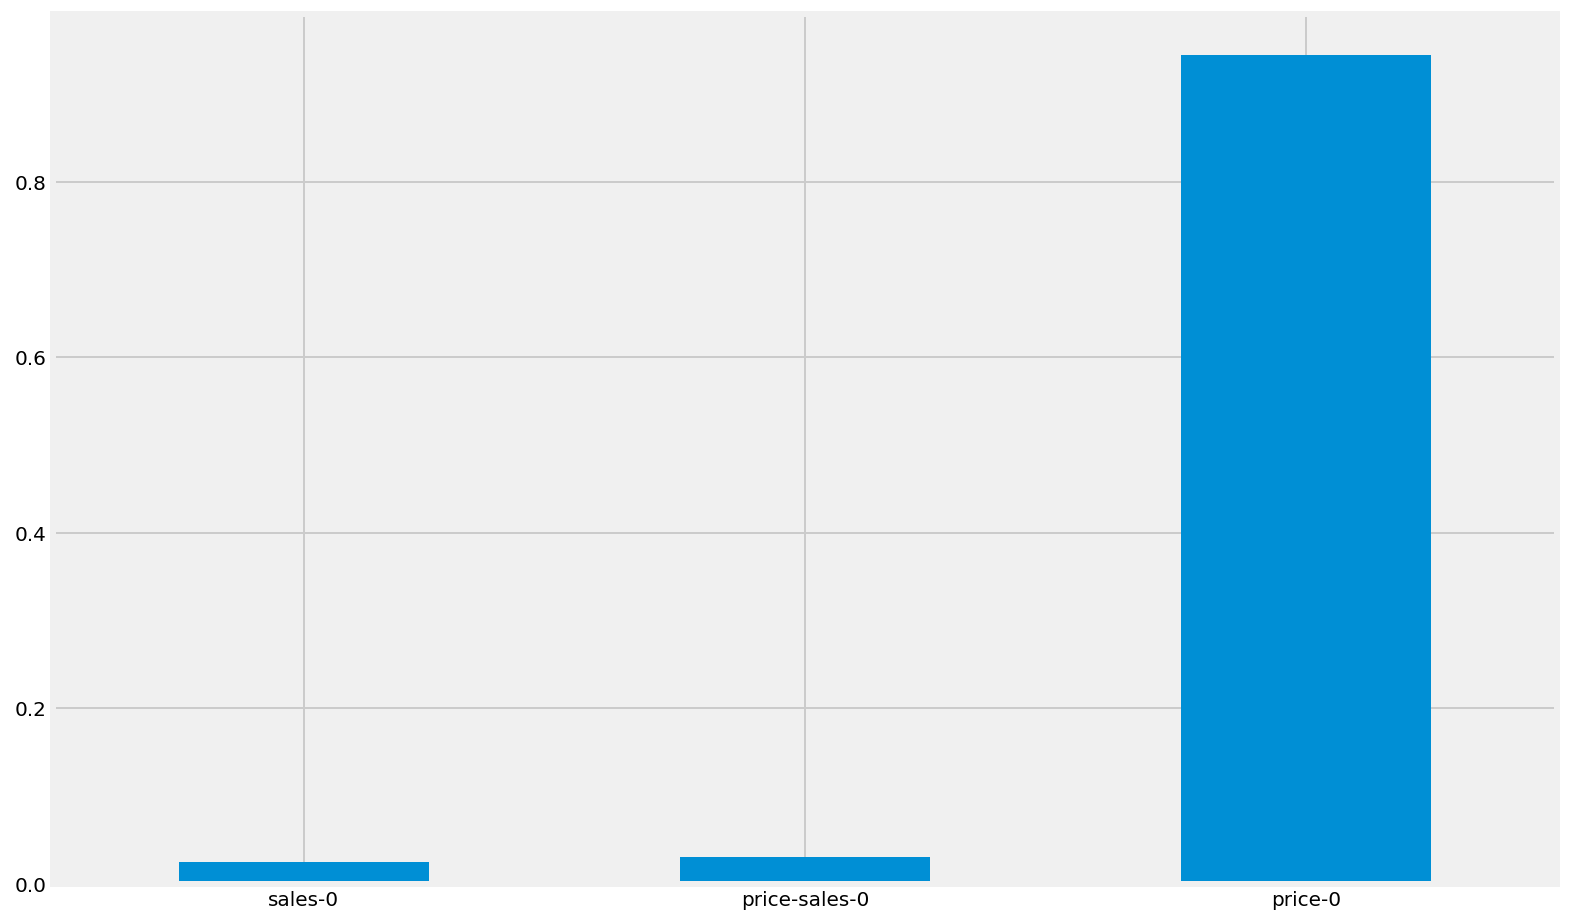

sales-0          0.024823
price-0          0.944447
price-sales-0    0.030730
dtype: float64
10.428548376491499
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9450181015477314
Fitting...
0.9365785682750435
Fitting...
0.9313785580672275
Fitting...
0.9363449794534333
Fitting...
0.9383752067110068
Fitting...
0.9430095954676941
Fitting...
0.9373437916076813
Fitting...
0.933075956556578
Fitting...
0.9399813715910353
Fitting...
0.93769308378305


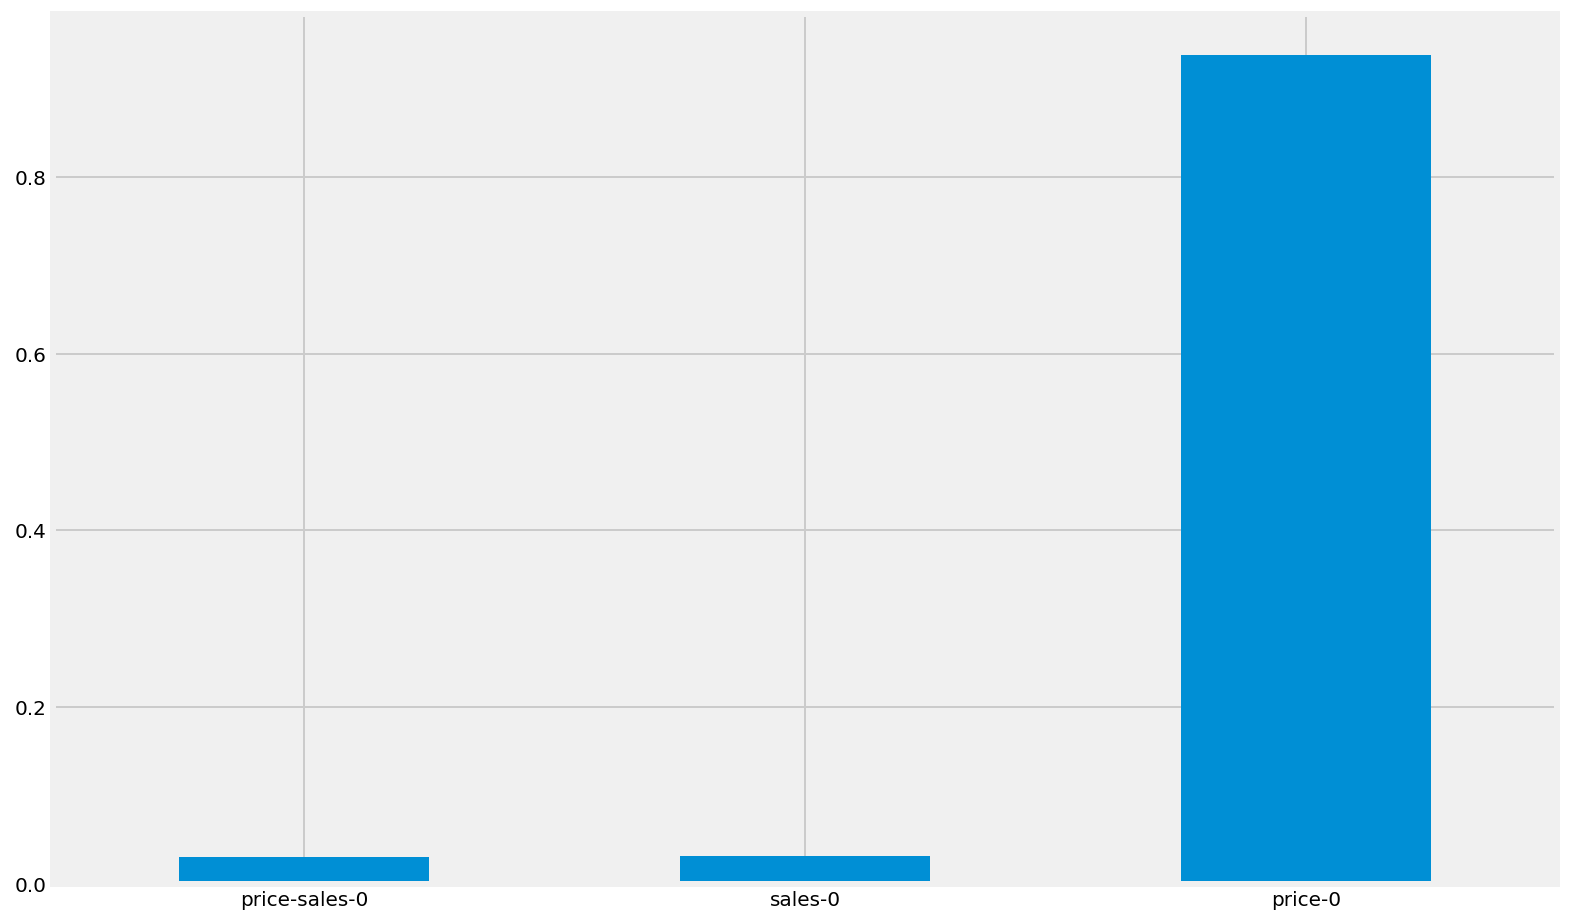

sales-0          0.031703
price-0          0.937907
price-sales-0    0.030390
dtype: float64
8.788758254776981
Working on RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)
Fitting...
0.9449569334937689
Fitting...
0.9369005468664408
Fitting...
0.9290479968119254
Fitting...
0.9414186164142084
Fitting...
0.9401518421975499
Fitting...
0.9396052496732071
Fitting...
0.9376285507596175
Fitting...
0.9357190030948188
Fitting...
0.9359727768334541
Fitting...
0.9359423278388141


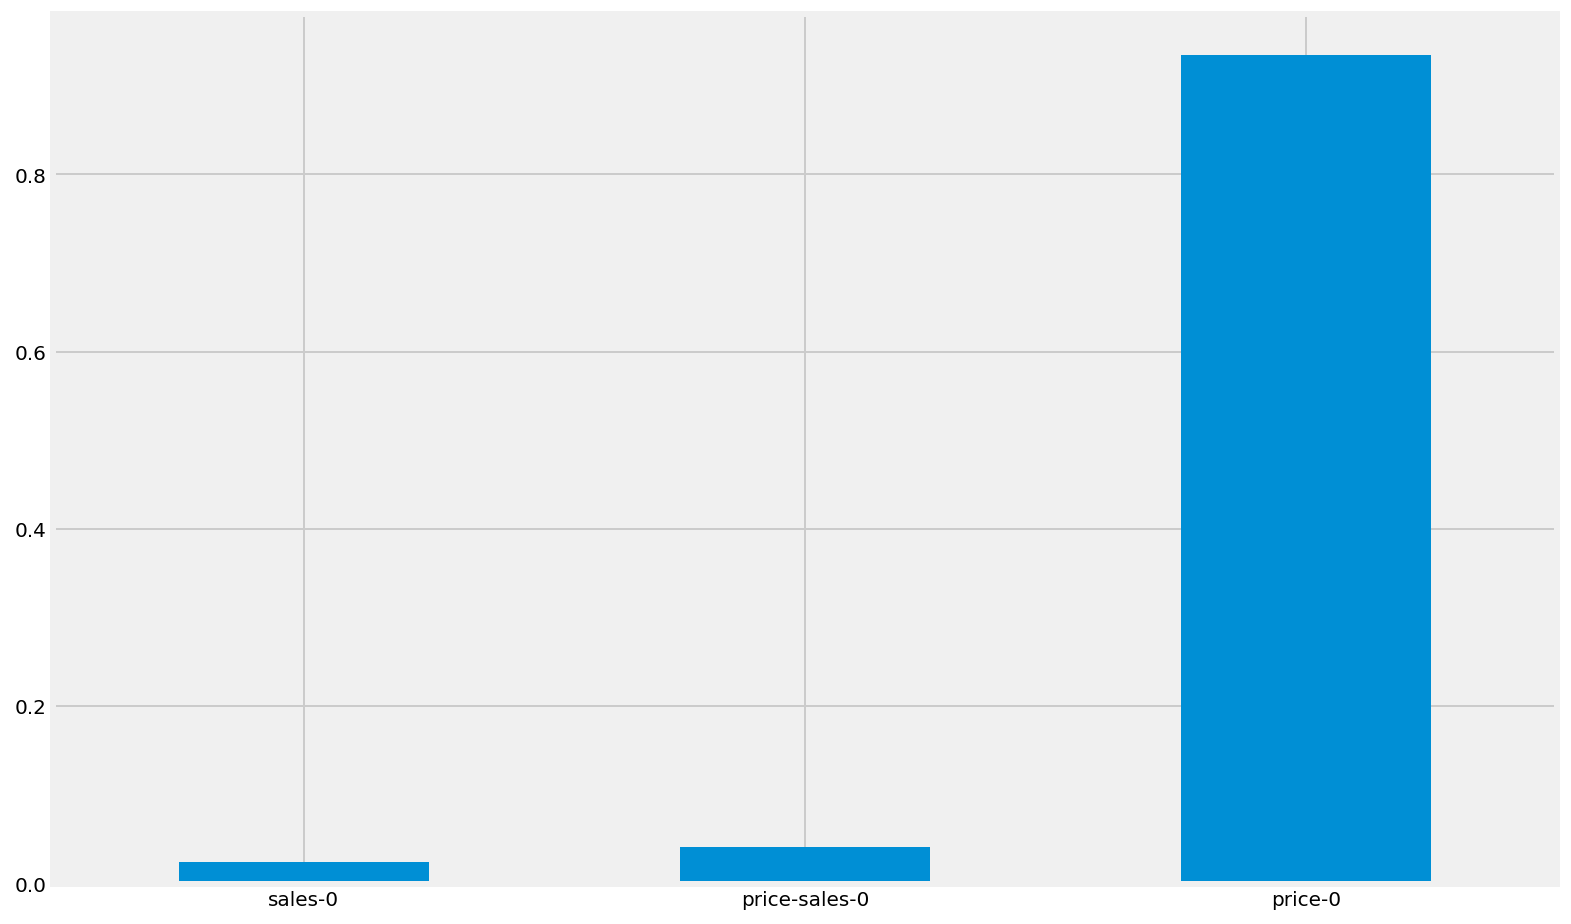

sales-0          0.024745
price-0          0.934451
price-sales-0    0.040804
dtype: float64
9.72835567146155
0     14.042195
1     11.300599
2     14.265064
3     10.185498
4     13.419874
5      9.306501
6     13.054521
7     12.192709
8     10.906169
9     10.428548
10     8.788758
11     9.728356
dtype: float64
MEAN MAPE ON SCOPE = 11.468232623692282


In [11]:
for lg_s in range(1,2):
    for lg_e in range(1,2):
        for lg_pr in range(1,2):
            for lg_p in range(1,2):
                print("Sales lag = {}, Price lag = {}, Promo lag = {}, Exposed lag = {}".format(lg_s, lg_p, lg_pr, lg_e))
                
                kfold_mean = []
                for skuId in dataset[dataset.scope == 1].sku.unique():
                    df_kfold = get_series(dataset, skuId=skuId, lags_sales=lg_s, lags_price=lg_p, lags_promo=0, lags_exposed=0, test_mode=False)
                    res_data = k_cross_validation(df_kfold).mean()
                    print(res_data)
                    kfold_mean.append(res_data)
                kfold_series = pd.Series(kfold_mean)
                print(kfold_series)
                print("MEAN MAPE ON SCOPE = {}".format(kfold_series.mean()))

Based on this analysis, it seems that the **Random Forest Feature Selection** procedure concludes that the main feature to predict the sales at time t is the price at the same time t. **The average mape is around 11.5**, which is decent but probably not efficient enough.

# Adaboost
We try to do the same analysis as before using the **Adaboost Regression**.

Sales lag = 1, Price lag = 1
Working on AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=1000, random_state=0)
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...


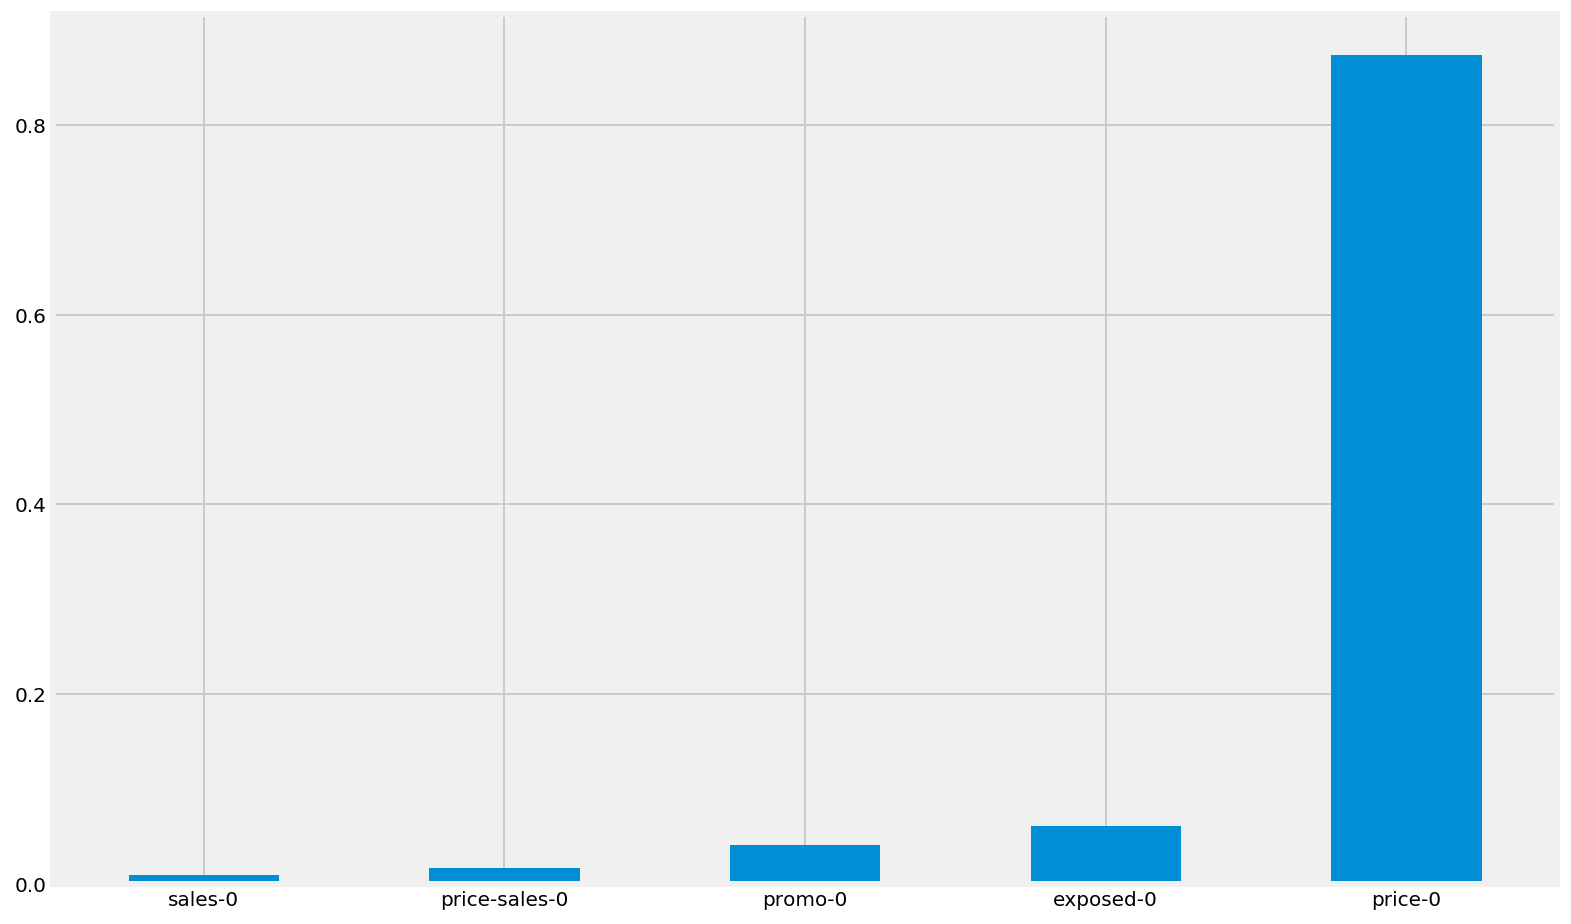

sales-0          0.009338
price-0          0.873380
exposed-0        0.060238
promo-0          0.041088
price-sales-0    0.015956
dtype: float64
15.793368972952326
Sales lag = 2, Price lag = 1
Working on AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=1000, random_state=0)
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...


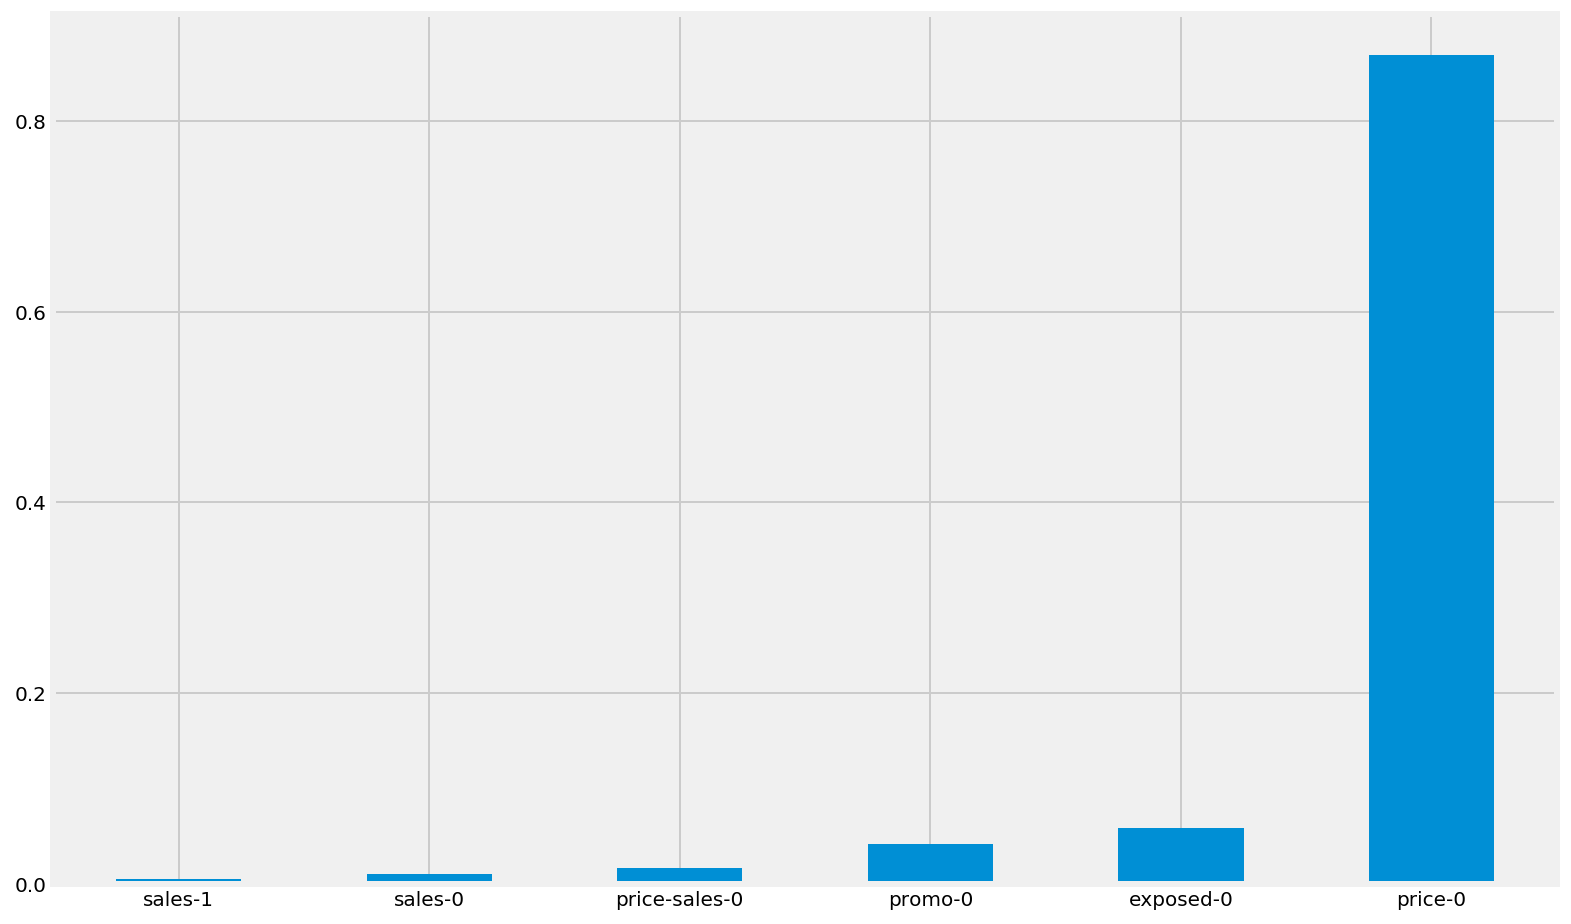

sales-1          0.004858
sales-0          0.009548
price-0          0.869058
exposed-0        0.058822
promo-0          0.041094
price-sales-0    0.016621
dtype: float64
15.191609674799167
Sales lag = 3, Price lag = 1
Working on AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=1000, random_state=0)
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...


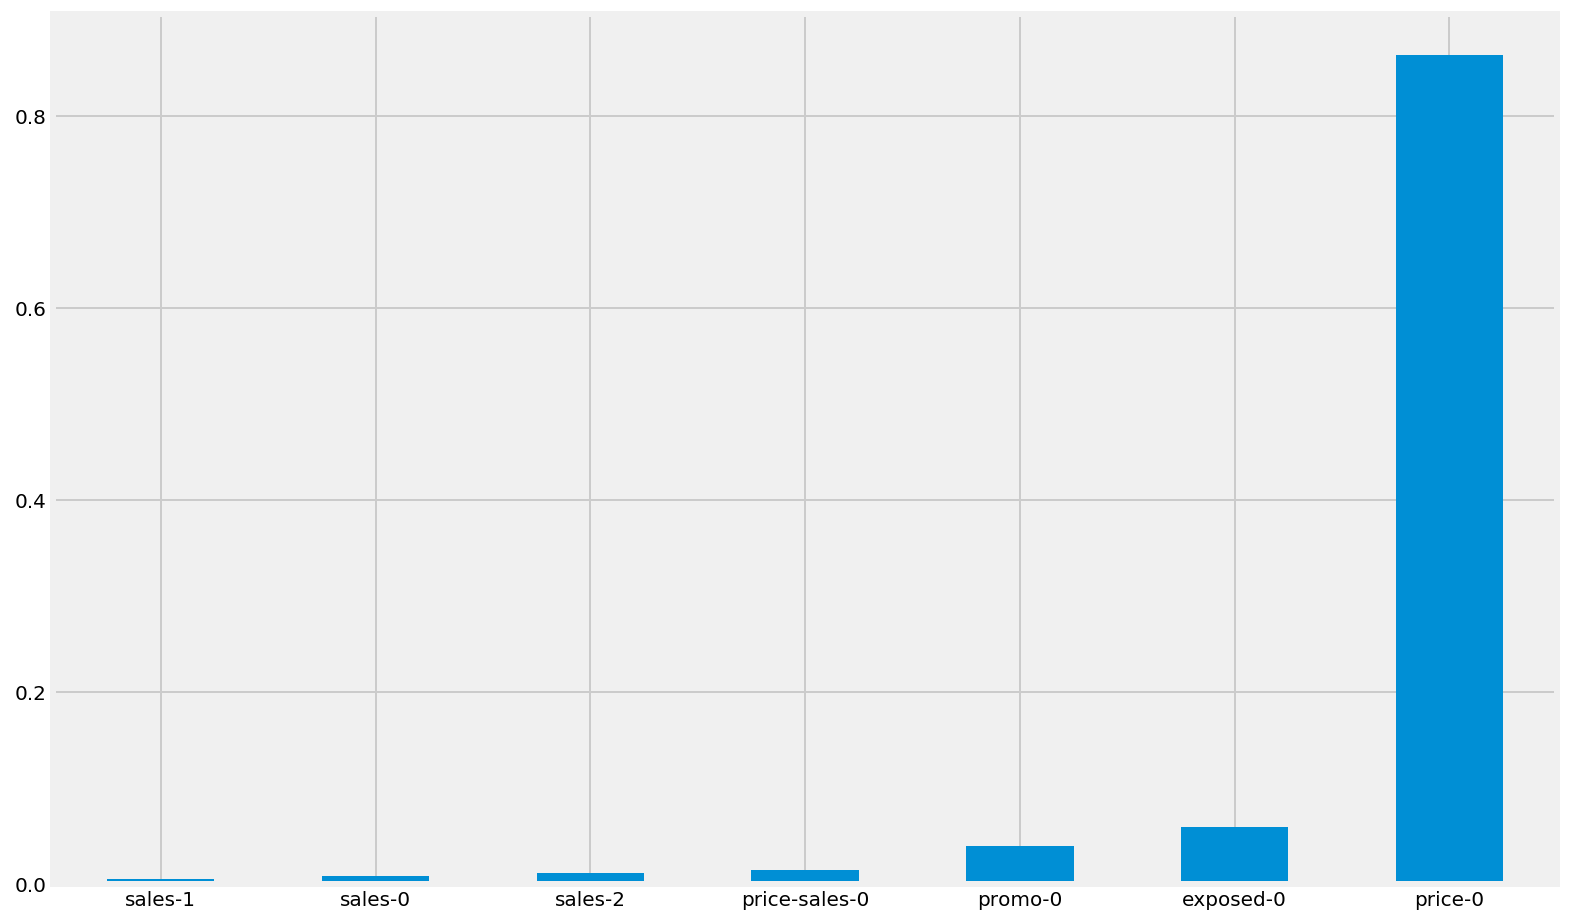

sales-2          0.011308
sales-1          0.004532
sales-0          0.008008
price-0          0.863528
exposed-0        0.058784
promo-0          0.039702
price-sales-0    0.014138
dtype: float64
15.088171195847044


In [12]:
for lg_s in range(1,4):
    for lg_e in range(1,2):
        for lg_pr in range(1,2):
            for lg_p in range(1,2):
                print("Sales lag = {}, Price lag = {}".format(lg_s, lg_p))
                df_kfold = get_series(dataset, skuId=144, lags_sales=lg_s, lags_price=lg_p, lags_promo=lg_pr, lags_exposed=lg_e, test_mode=False)
                print(k_cross_validation(df_kfold, model=AdaBoostRegressor(random_state=0, n_estimators=1000)).mean())

The result about the most important feature seems the same. The mape is slightly worst.

# Lasso

Sales lag = 1, Price lag = 1
Working on Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...


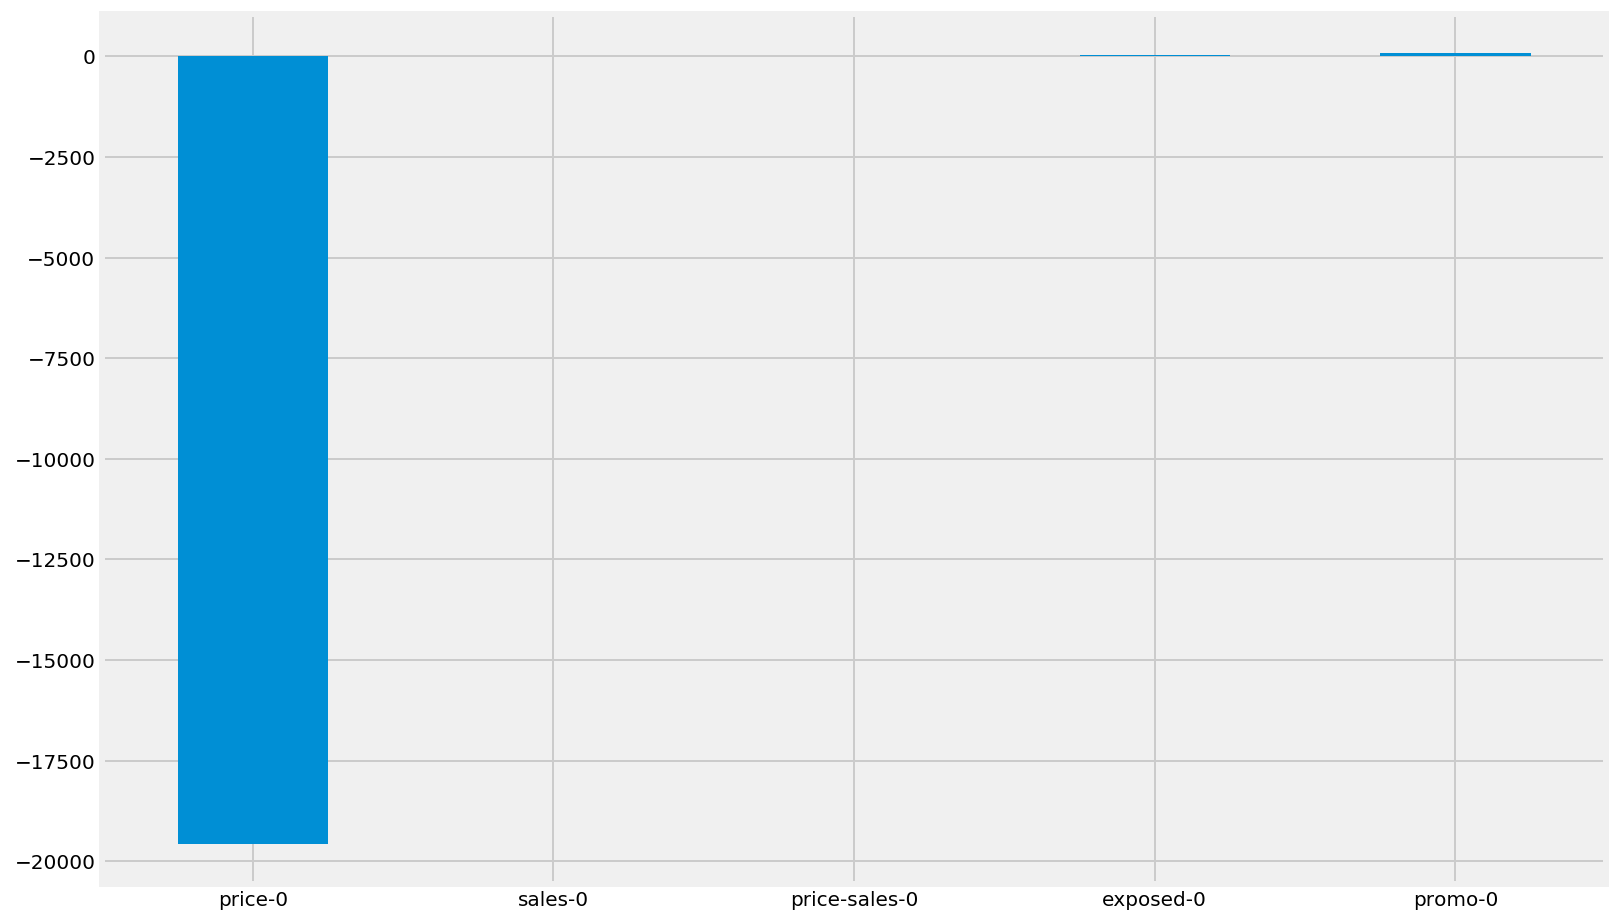

sales-0             -1.615254
price-0         -19574.118917
exposed-0           28.319010
promo-0             71.948040
price-sales-0        3.541249
dtype: float64
22.084936886287988
Sales lag = 2, Price lag = 1
Working on Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...
Fitting...


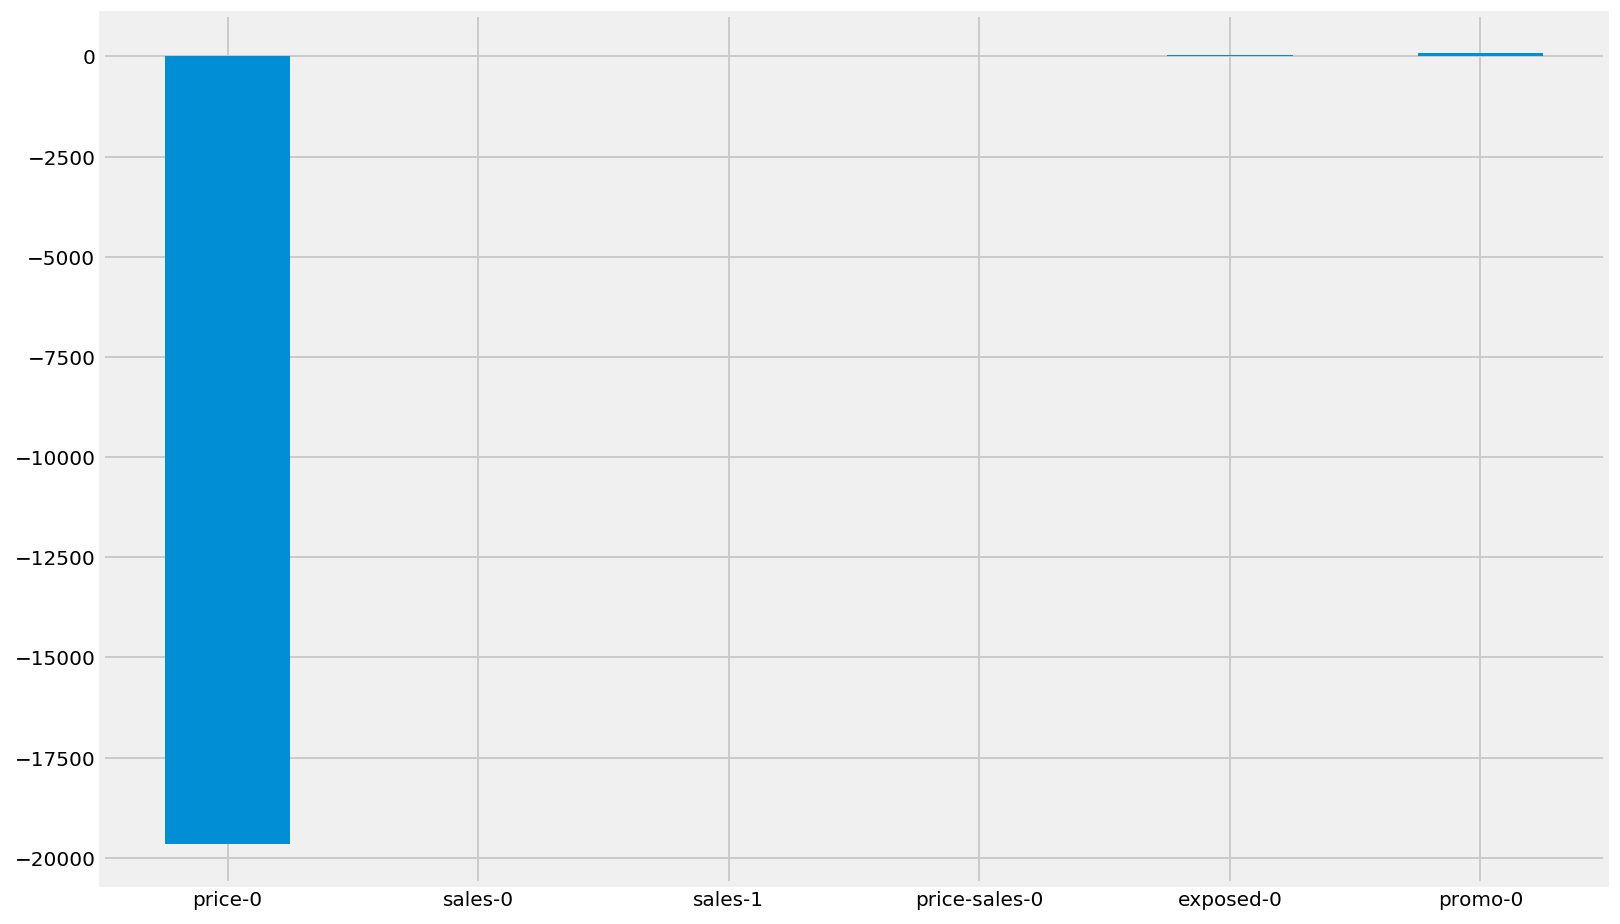

sales-1              0.009170
sales-0             -1.650121
price-0         -19657.792964
exposed-0           45.599862
promo-0             74.676360
price-sales-0        3.567684
dtype: float64
22.422007951834196


In [15]:
for lg_s in range(1,3):
    for lg_e in range(1,2):
        for lg_pr in range(1,2):
            for lg_p in range(1,2):
                print("Sales lag = {}, Price lag = {}".format(lg_s, lg_p))
                df_kfold = get_series(dataset, skuId=144, lags_sales=lg_s, lags_price=lg_p, lags_promo=lg_pr, lags_exposed=lg_e, test_mode=False)
                print(k_cross_validation(df_kfold, model=Lasso(alpha=0.1, random_state=0)).mean())

We collect more information from **Lasso**. The mape is still high, around 20, and the most importance feature still seems to be the price at time t. However, the feature selection seems to take in consideration also the price in other time instants and the difference between prices.

# Random Forest Prediction

In [16]:
model = RandomForestRegressor(n_estimators=10000, random_state=1)

In [17]:
df_predictions = pd.DataFrame(columns=['date', 'sku', 'prediction']) 

In [18]:
def prediction(skuId):
    global df_predictions
    print("On Sku {}".format(skuId))
    train = get_series(dataset, skuId=skuId, lags_sales=2, lags_price=1, lags_exposed=0, lags_promo=0, test_mode=False)
    test = get_series(dataset, skuId=skuId, lags_sales=2, lags_price=1, lags_exposed=0, lags_promo=0, test_mode=True)
    dtm = testset[testset.sku == skuId].index.strftime('WE %d %B %Y').array
    
    model.fit(train.drop(columns=['target']), train.target)
    pred = model.predict(test)
    df_predictions = df_predictions.append(pd.DataFrame({
        'date': dtm,
        'sku': np.full(shape=len(testset[testset.sku == skuId]), fill_value=skuId), 'prediction': pred}))

In [19]:
for skuId in testset.sku.unique():
    prediction(skuId)

On Sku 1027
On Sku 1035
On Sku 144
On Sku 1051
On Sku 546
On Sku 1058
On Sku 549
On Sku 1065
On Sku 554
On Sku 686
On Sku 688
On Sku 1206


In [20]:
df_predictions.set_index('date', inplace=True)
df_predictions.index.name = None
df_predictions

,sku,prediction
WE 29 June 2019,1027,62598.1535
WE 06 July 2019,1027,51766.9066
WE 13 July 2019,1027,85566.6775
WE 20 July 2019,1027,75614.0292
WE 27 July 2019,1027,89034.2332
...,...,...
WE 16 November 2019,1206,74418.3971
WE 23 November 2019,1206,51613.3527
WE 30 November 2019,1206,43908.9148
WE 07 December 2019,1206,46016.8996


In [21]:
for skuId in df_predictions.sku.unique():
    print("Sku {} with {} rows".format(skuId, len(df_predictions[df_predictions.sku == skuId])))

Sku 1027 with 25 rows
Sku 1035 with 25 rows
Sku 144 with 25 rows
Sku 1051 with 25 rows
Sku 546 with 25 rows
Sku 1058 with 25 rows
Sku 549 with 25 rows
Sku 1065 with 25 rows
Sku 554 with 25 rows
Sku 686 with 25 rows
Sku 688 with 25 rows
Sku 1206 with 25 rows


sku
144     [AxesSubplot(0.08,0.2;0.87x0.68)]
546     [AxesSubplot(0.08,0.2;0.87x0.68)]
549     [AxesSubplot(0.08,0.2;0.87x0.68)]
554     [AxesSubplot(0.08,0.2;0.87x0.68)]
686     [AxesSubplot(0.08,0.2;0.87x0.68)]
688     [AxesSubplot(0.08,0.2;0.87x0.68)]
1027    [AxesSubplot(0.08,0.2;0.87x0.68)]
1035    [AxesSubplot(0.08,0.2;0.87x0.68)]
1051    [AxesSubplot(0.08,0.2;0.87x0.68)]
1058    [AxesSubplot(0.08,0.2;0.87x0.68)]
1065    [AxesSubplot(0.08,0.2;0.87x0.68)]
1206    [AxesSubplot(0.08,0.2;0.87x0.68)]
Name: prediction, dtype: object

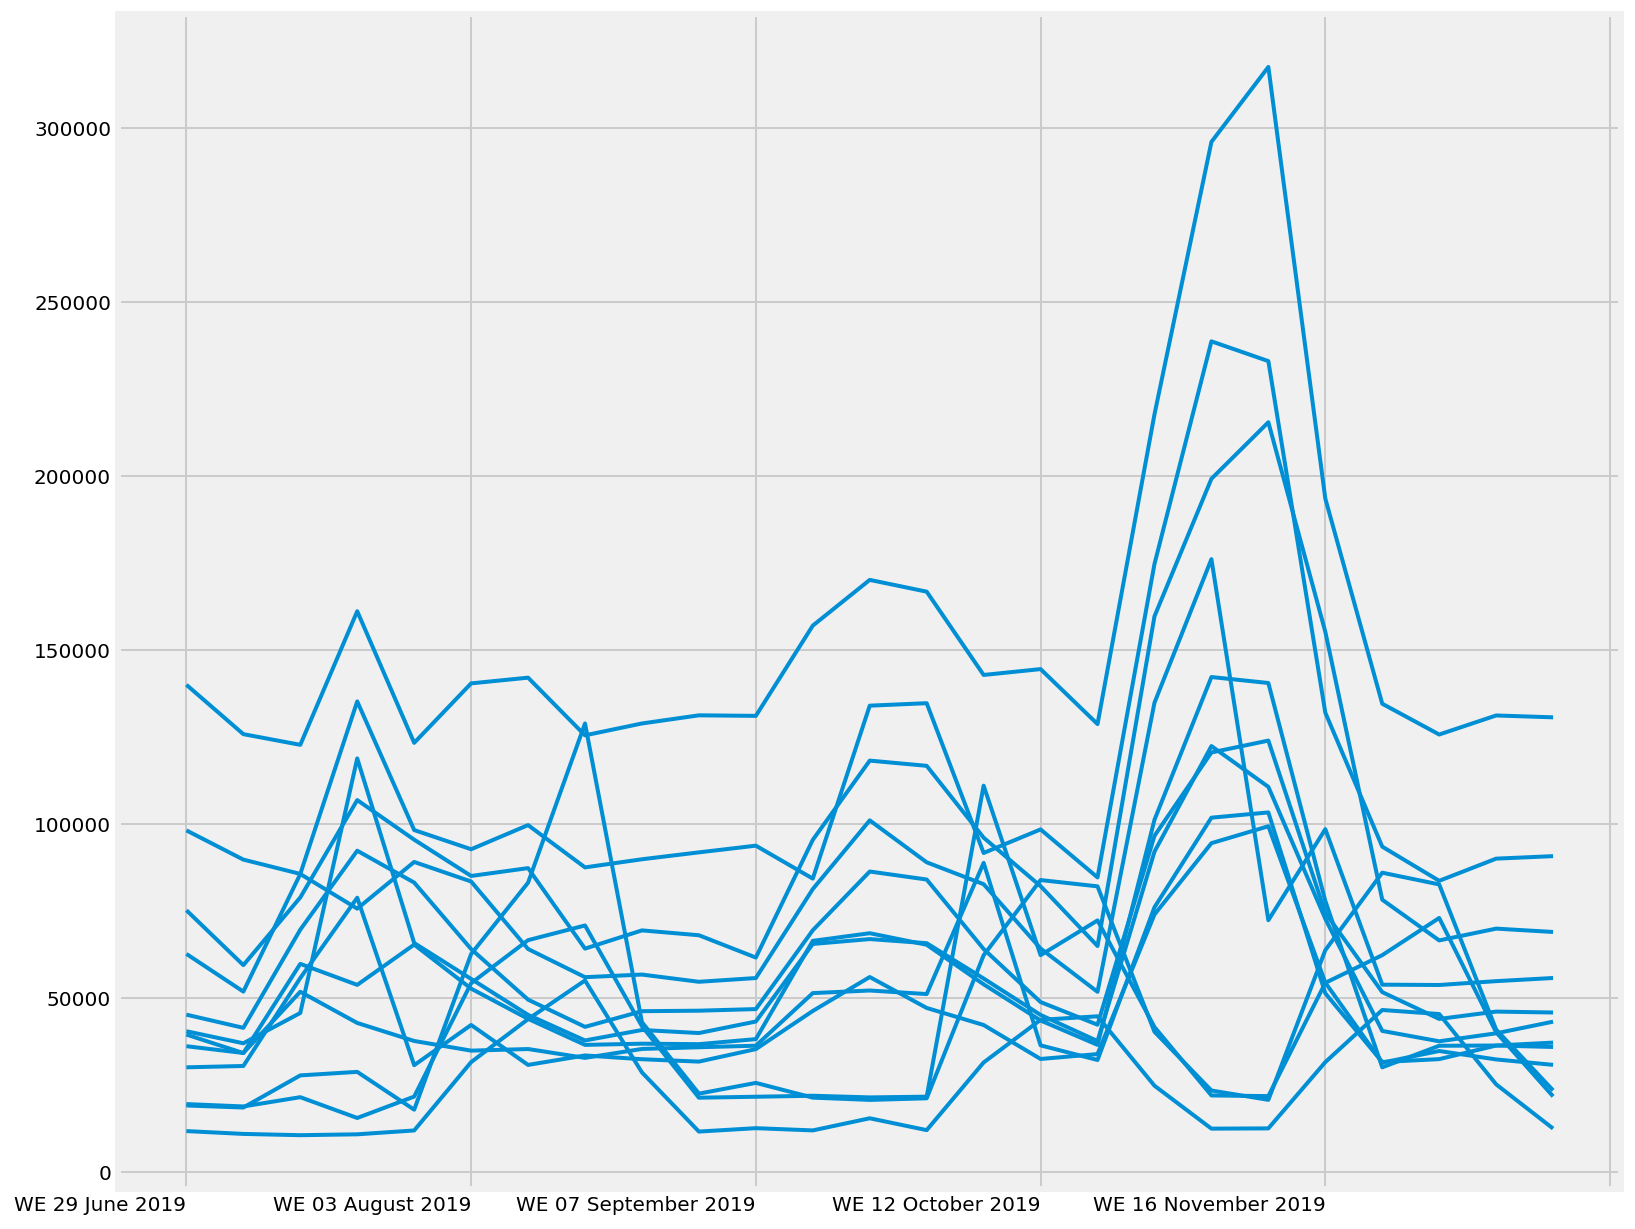

In [22]:
df_predictions.groupby('sku').prediction.plot(figsize=(12, 12), subplots=True)

In [23]:
df_predictions.to_csv('./data/Prediction.csv', index=True)